In [1]:
library(ggplot2)
library(dplyr)
library(paletteer)
library(ggpubr)

library(RColorBrewer)
library(scales)
library(pals)
library(gridExtra)

library(SingleCellExperiment)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarD

In [2]:
source("~/public/SiyuanLuo/projects/benchmark/scripts/evaluation/lib_metrics.R")
source("~/public/SiyuanLuo/projects/benchmark/scripts/clustering/lib_clustering.R")
# source("~/public/SiyuanLuo/projects/benchmark/scripts/feature_engineering/func_aggregation.R")

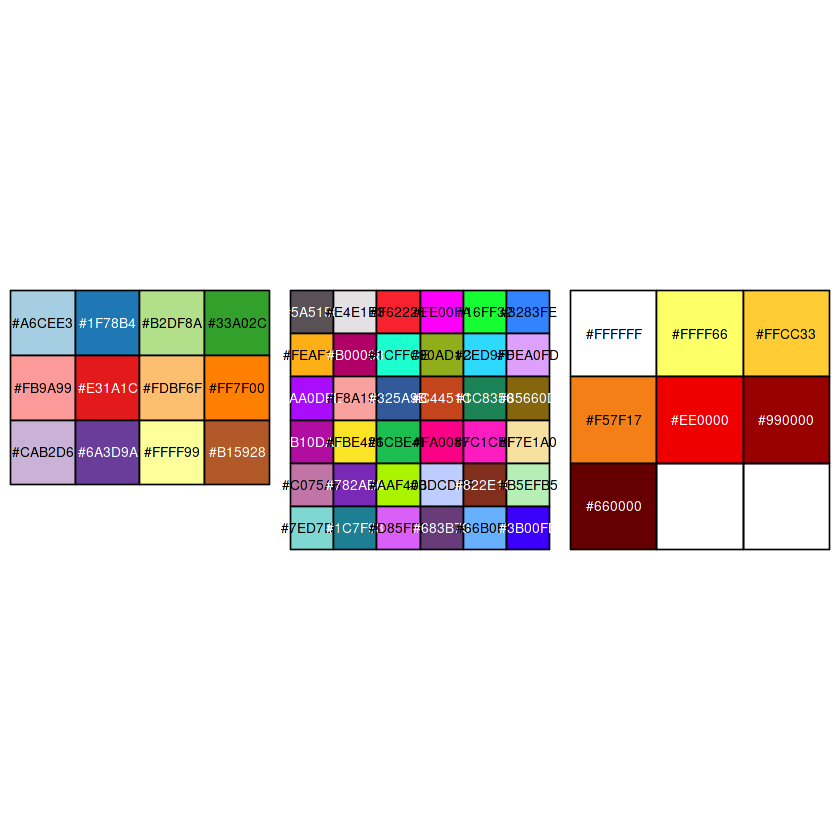

In [3]:
par(mfrow=c(1,3))
# method color
my_col_m <- brewer.pal(12, "Paired")
show_col(my_col_m)
# cell type color
my_col_c <- unlist(polychrome())
show_col(my_col_c)

my_color <- c("#FFFFFF","#FFFF66","#FFCC33","#F57F17","#EE0000","#990000","#660000")
show_col(my_color)

In [4]:
dataset_ls <- c("Buenrostro_2018", "candidate1", "Cell_line_mixing", "Chen_2019",  "PBMC_multiomics") #"Ma_2019",
k_ls <- c(9, 13, 10, 13, 15)

In [5]:
get_df <- function(dataset){
    df <- read.table(paste0("~/public/SiyuanLuo/projects/benchmark/outputs/", dataset, "/metric_file.tsv"), sep="\t", header=TRUE)
    setwd(paste0("~/public/SiyuanLuo/projects/benchmark/outputs/", dataset))

    df$rds_file <- gsub("_metrics.tsv", "_evaluation.RDS", df$file)
    df["clustering_file"] <- gsub("evaluation", "clustering", df$file)
    df["clustering_file"] <- gsub("_metrics", "", df$clustering_file)
    df["long_method"] <- paste(df$method, df$feature_type, df$distance, sep="_")
    df$long_method <-gsub("_default","",as.character(df$long_method))
    df$snn_file <- paste0(dirname(df$clustering_file), "/sobj_SNN.RDS")

    df$n_clusters <- 0
    for (i in 1:length(df$clustering_file)){
        clusterings <- read.table(df$clustering_file[i])
        df[i, "n_clusters"] <- max(clusterings$clusterings)
    }
    df_metrics <- data.frame(matrix(ncol = 13, nrow = 0))
    colnames(df_metrics) <- c("n_clusters","metric","value","method",
                            "long_method","feature_type","tile_size",
                            "distance","ndim","resolution","rds_file", 
                            "clustering_file", "snn_file")

    j <- 1
    for(i in 1:dim(df)[1]){
        file <- df$file[i]
        df_metric <- read.table(df$file[i], sep="\t", header=TRUE)
        for(metric in rownames(df_metric)){
            df_metrics[j, "metric"] <- metric
            df_metrics[j, "value"] <- df_metric[metric, "value"]
            df_metrics[j ,c("n_clusters","method","feature_type","tile_size","distance","ndim","resolution", 
                            "long_method", "rds_file", "clustering_file", "snn_file")] <- df[i, c("n_clusters","method","feature_type",
                                                                                                "tile_size","distance","ndim","resolution",
                                                                                                "long_method", "rds_file", "clustering_file", 
                                                                                                "snn_file")]
            j <- j+1
        }
    }

    df_metrics$resolution <- as.numeric(df_metrics$resolution)
    return(list(df=df, df_metrics=df_metrics))
}

In [6]:
ndim_visualize <- function(dataset, df_metrics, k_optimal){
    df_metrics$n_clusters_d <- abs(df_metrics$n_clusters - k_optimal)
    df_metrics_optimal_k <- df_metrics  %>%
    group_by(long_method, ndim) %>%
    filter(n_clusters_d == min(n_clusters_d))  %>%
    ungroup()

    options(repr.plot.width=12, repr.plot.height=8)
    p1 <-
    df_metrics_optimal_k %>% 
    group_by(long_method, metric, ndim) %>%
    mutate(mean_value = mean(value)) %>%
    ggplot(aes(x=ndim, y=value, color=long_method)) + 
    geom_point(size=0.8) +
    geom_line(size=0.5, aes(x=ndim, y=mean_value, color=long_method)) + 
    facet_wrap(~metric, scales = "free") + 
    xlab("number of dimension") +
    ylab("value") +
    # geom_vline(xintercept=0.8, linetype="dashed", color = "grey") +
    theme_bw() +
    scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)])

    options(repr.plot.width=12, repr.plot.height=8)
    p2 <- df_metrics %>% 
    ggplot(aes(x=resolution, y=n_clusters, color=long_method)) + 
    geom_line(size=0.5) + 
    geom_point(size=0.8) +
    facet_wrap(~ndim, scales = "free") + 
    xlab("resolution") +
    ylab("number of clusters") +
    theme_bw() +
    scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)]) 


    df_metrics_ari <- df_metrics %>% filter(metric == "ARI" | metric == "ARI2") %>% mutate(group = paste(metric, ndim, sep="-"))
    df_metrics_ari$group <- factor(df_metrics_ari$group, levels = c("ARI-15", "ARI-30", "ARI-50","ARI-100","ARI2-15","ARI2-30","ARI2-50","ARI2-100"))

    options(repr.plot.width=16, repr.plot.height=15)

    p3 <-
    df_metrics_ari %>% filter(n_clusters <= 30) %>% 
    group_by(long_method, metric, n_clusters, ndim) %>%
    mutate(mean_value = mean(value)) %>%
    ggplot(aes(x=n_clusters, y=value, color=long_method)) + 
    geom_point(size=2) +
    geom_line(size=0.8, aes(x=n_clusters, y=mean_value, color=long_method)) + 
    facet_wrap(~group, scales = "free") + 
    xlab("number of clusters") +
    ylab("value") +
    geom_vline(xintercept=k_optimal, color = "red", linetype = "dashed") +
    theme_bw() +
    scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)]) #+ ylim(0, 0.8)

    options(repr.plot.width=16, repr.plot.height=15)

    p4 <-
    df_metrics_ari %>% filter(n_clusters <= 30) %>% filter(metric=="ARI") %>% #filter(grepl(n,ndim)) %>%
    group_by(long_method, metric, n_clusters, ndim) %>%
    mutate(mean_value = mean(value)) %>%
    ggplot(aes(x=n_clusters, y=value, color=group)) + 
    geom_point(size=2) +
    geom_line(size=0.8, aes(x=n_clusters, y=mean_value, color=group)) + 
    facet_wrap(~long_method, scales = "free") + 
    xlab("number of clusters") +
    ylab("value") +
    geom_vline(xintercept=k_optimal, color = "red", linetype = "dashed") +
    theme_bw() +
    # geom_errorbar(aes(ymin = min_value, ymax = max_value), width = 0.2, linetype = "dashed") +
    scale_colour_manual(values = brewer.pal(10, "Paired")) #+ ylim(0, 0.8)

    pdf(paste0("/home/siluo/public/SiyuanLuo/projects/benchmark/scripts/analysis/ndim_", dataset, ".pdf"), width=12, height=8)
    print(p1)
    print(p2)
    print(p3)
    print(p4)
    graphics.off()
}


In [7]:
cross_table_plot <- function(ground_truth, clusterings, a=1.3, b=5.7, c=2){
    x <- unique(ground_truth)
    y <- as.factor(unique(clusterings))
    data <- expand.grid(X=x, Y=y)
    cross_count <- table(ground_truth, clusterings) 

    # cell count in the cross_count table
    data$Z1 <- apply(data, 1, function(x){cross_count[x[["X"]],as.numeric(x[["Y"]])]})
    # log transform Z1
    data$Z2 <- apply(data, 1, function(x){log(cross_count[x[["X"]],as.numeric(x[["Y"]])]+1)})
    # row normalize of Z1
    data <- data %>% group_by(X) %>% mutate(Z3 = 100*Z1/sum(Z1))

    top_cluster <- data %>% group_by(X) %>% top_n(1, Z1)

    unselected_Y <- setdiff(unique(data$Y), unique(top_cluster$Y))
    top_cluster <- top_cluster[order(top_cluster$X),]
    new_levels <- as.numeric(c(as.character(unique(top_cluster$Y)),unselected_Y))
    data$Y <- factor(data$Y, levels=new_levels)

    res <- adjusted_wallance_indices(ground_truth, clusterings)

    df_awi <- do.call(rbind, Map(data.frame, "awi"=res$Awi))
    df_awi$cell_type <- levels(ground_truth)

    df_avj <- do.call(rbind, Map(data.frame, "avj"=res$Avj))
    df_avj$cell_type <- levels(clusterings)
    df_avj$cell_type <- factor(df_avj$cell_type, levels=new_levels)


    main <- ggplot(data, aes(Y, X, fill= Z3)) + 
    geom_tile(colour="black", size=0.1) + 
    scale_fill_gradientn(colours = my_color, breaks=seq(0,100,10), guide = guide_colourbar()) +
    labs(x="ATAC cluster", y="RNA cluster", fill = "Cells per RNA cluster %") + 
    theme(legend.direction = "horizontal", 
        legend.position = "bottom", 
        legend.key.width= unit(a, 'cm'),
        legend.text=element_text(size=12)) + 
    theme(plot.margin = unit(c(0, 0, 0, 1), "cm"),
        panel.background = element_blank(),
        axis.title.x = element_text(size = 15, margin = margin(5,0,0,0)), 
        axis.text.x = element_text(size = 12),
        axis.title.y = element_text(size = 15, margin = margin(0,0,0,0)), 
        axis.text.y = element_text(size = 12),)

    bp.x <- ggplot(data = df_avj, aes(x = cell_type, y = avj)) + 
    geom_bar(stat = "identity") + 
    theme(
        axis.title.x = element_blank(), 
        axis.text.x = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.text.y = element_text(size=12), 
        axis.title.y = element_text(size = 15, margin = margin(10,5,0,0)),
        legend.position = "none",
        panel.background = element_blank()) + 
    labs(y = "Homogeneity")+ theme(plot.margin = unit(c(0, 0, 0, b), "cm"))

    bp.y <- ggplot(data = df_awi, aes(x = cell_type, y = awi)) + 
    geom_bar(stat = "identity") + coord_flip() + # theme_ipsum() + #theme_gray() +
    theme(axis.title.x = element_text(size = 15, margin = margin(5,5,0,0)), 
          axis.text.x = element_text(size = 12),
          axis.text.y = element_blank(), 
          axis.title.y = element_blank(), 
          axis.ticks.y = element_blank(), 
          legend.position="none",
          panel.background = element_blank()) + 
    labs(y="Completemess")+ theme(plot.margin = unit(c(0, 0, c, 0), "cm"))

    df_hm <- data.frame(cols = numeric(0), value = numeric(0))

    gg_empty <- df_hm %>% 
    ggplot(aes(x = cols, y = value)) +
    geom_blank() +
    theme(axis.text = element_blank(),
            axis.title = element_blank(),
            line = element_blank(),
            panel.background = element_blank()) + 
            geom_text(aes(label = paste0("ARI = ", round(res$ARI,3), "\n", "ARI2 = ", round(res$ARI2,3))), x = 0.5, y = 0.5)

    plot <- ggarrange(
    bp.x, gg_empty, main, bp.y,
    nrow = 2, ncol = 2, widths = c(3, 1), heights = c(1, 3)
    )

    return(plot)
}

## Buenrostro_2018

In [8]:
i <- 1
dataset <- dataset_ls[i]
k_optimal <- k_ls[i]

In [8]:
# print(dataset)
# ls <- get_df(dataset)
# df <- ls$df
# df_metrics <- ls$df_metrics
# print(k_optimal)

[1] "Buenrostro_2018"


In [13]:
# write.table(df, file = "meta_info_for_evaluation.tsv", sep = "\t", quote = FALSE)
# write.table(df_metrics, file = "metrics_value.tsv", sep = "\t", quote = FALSE)

In [9]:
setwd(paste0("/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/", dataset))
df <- read.table(file="meta_info_for_evaluation.tsv", sep="\t", header=TRUE)
df_metrics <- read.table(file="metrics_value.tsv", sep="\t", header=TRUE)

In [12]:
# ndim_visualize(dataset, df_metrics, k_optimal)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


Check why the performance of agg drop so much between two different run

The performance of using 30 vs 100 dimensions are identical. So the difference is due to the large randomness of the agg method.

In [10]:
setwd(paste0("/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/", dataset, "/", dataset))

### First run

In [11]:
embedding_file <- "feature_engineering/R/aggregation/default/500/default/archive/30.tsv"
sobj <- readRDS("clustering/aggregation/default/500/default/30/sobj_SNN.RDS")
sobj1 <- add_embedding(sobj, embedding_file, embed_name="test_30", max_dim=30)
sobj2 <- add_embedding(sobj, embedding_file, embed_name="test_100", max_dim=100)

Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:100'”


In [12]:
dim(sobj1@reductions[["test_30"]])
dim(sobj2@reductions[["test_100"]])

[1] 1715   30

[1] 1715  100

In [13]:
embed_ls <- c("test_30", "test_100")
r_ls <- c(0.05, 0.1, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3,0.4,0.5)

embed_name <- embed_ls[1]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj1 <- FindNeighbors(object = sobj1, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj1@graphs[[name1]] <- as.Graph(sobj1@graphs[[name1]])
sobj1@graphs[[name2]] <- as.Graph(sobj1@graphs[[name2]])
ndim0 <- dim(sobj1@reductions[[embed_name]])[2]
sobj1 <- RunUMAP(sobj1, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj1 <- FindClusters(object = sobj1, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj1$seurat_clusters
}

embed_name <- embed_ls[2]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj2 <- FindNeighbors(object = sobj2, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj2@graphs[[name1]] <- as.Graph(sobj2@graphs[[name1]])
sobj2@graphs[[name2]] <- as.Graph(sobj2@graphs[[name2]])
ndim0 <- dim(sobj2@reductions[[embed_name]])[2]
sobj2 <- RunUMAP(sobj2, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj2 <- FindClusters(object = sobj2, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj2$seurat_clusters
}


Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:46:02 UMAP embedding parameters a = 0.9922 b = 1.112

20:46:02 Read 1715 rows and found 30 numeric columns

20:46:02 Using Annoy for neighbor search, n_neighbors = 30

20:46:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:46:03 Writing NN index file to temp file /media/siluo/c55ed6ce-672c-4a68-b60e-cef07edf5933/scratch/Rtmp0A6pzg/file22ea276cd65ae

20:46:03 Searching Annoy index using 1 thread, search_k = 3000

20:46:03 Annoy recal

In [15]:
df <- data.frame(ARI=c(), resolution=c(), method=c(), n_cluster=c())

embed_name <- embed_ls[1]
for(r in r_ls){
pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
ari <- aricode::ARI(sobj1$ground_truth, pred)
# print(embed_name)
# print(ari)
# print(max(as.numeric(unique(pred))))
df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred)))))
}   

embed_name <- embed_ls[2]
for(r in r_ls){
pred <- sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
ari <- aricode::ARI(sobj2$ground_truth, pred)
# print(embed_name)
# print(ari)
# print(max(as.numeric(unique(pred))))
df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred)))))
}   
df$run <- 1

In [16]:
df

ARI       resolution method   n_cluster run
1  0.4150167 0.050      test_30   5        1  
2  0.5452408 0.100      test_30   7        1  
3  0.6752045 0.150      test_30   9        1  
4  0.6752045 0.175      test_30   9        1  
5  0.4903475 0.200      test_30  10        1  
6  0.6918607 0.225      test_30  10        1  
7  0.6897254 0.250      test_30  10        1  
8  0.5511303 0.300      test_30  11        1  
9  0.5315021 0.400      test_30  12        1  
10 0.5315021 0.500      test_30  12        1  
11 0.4150167 0.050      test_100  5        1  
12 0.5452408 0.100      test_100  7        1  
13 0.6752045 0.150      test_100  9        1  
14 0.6752045 0.175      test_100  9        1  
15 0.4903475 0.200      test_100 10        1  
16 0.6918607 0.225      test_100 10        1  
17 0.6897254 0.250      test_100 10        1  
18 0.5511303 0.300      test_100 11        1  
19 0.5315021 0.400      test_100 12        1  
20 0.5315021 0.500      test_100 12        1

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


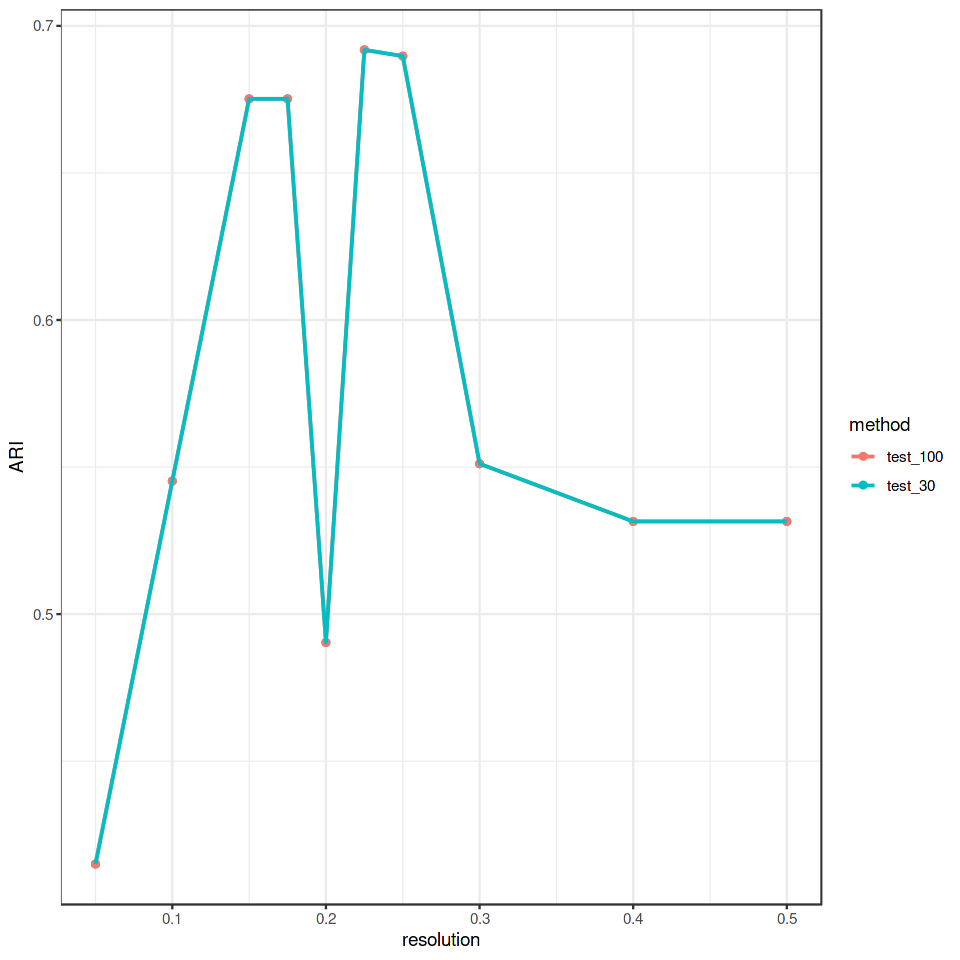

In [17]:
options(repr.plot.width=8, repr.plot.height=8)

df %>% 
  ggplot(aes(x=resolution, y=ARI, color=method)) + 
  geom_point(size=1.5) +
  geom_line(size=0.8, aes(x=resolution, y=ARI, color=method)) + 
  xlab("resolution") +
  ylab("ARI") +
#   geom_vline(xintercept=15, color = "red", linetype = "dashed") +
  theme_bw() #+
  # geom_errorbar(aes(ymin = min_value, ymax = max_value), width = 0.2, linetype = "dashed") +
#   scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)])

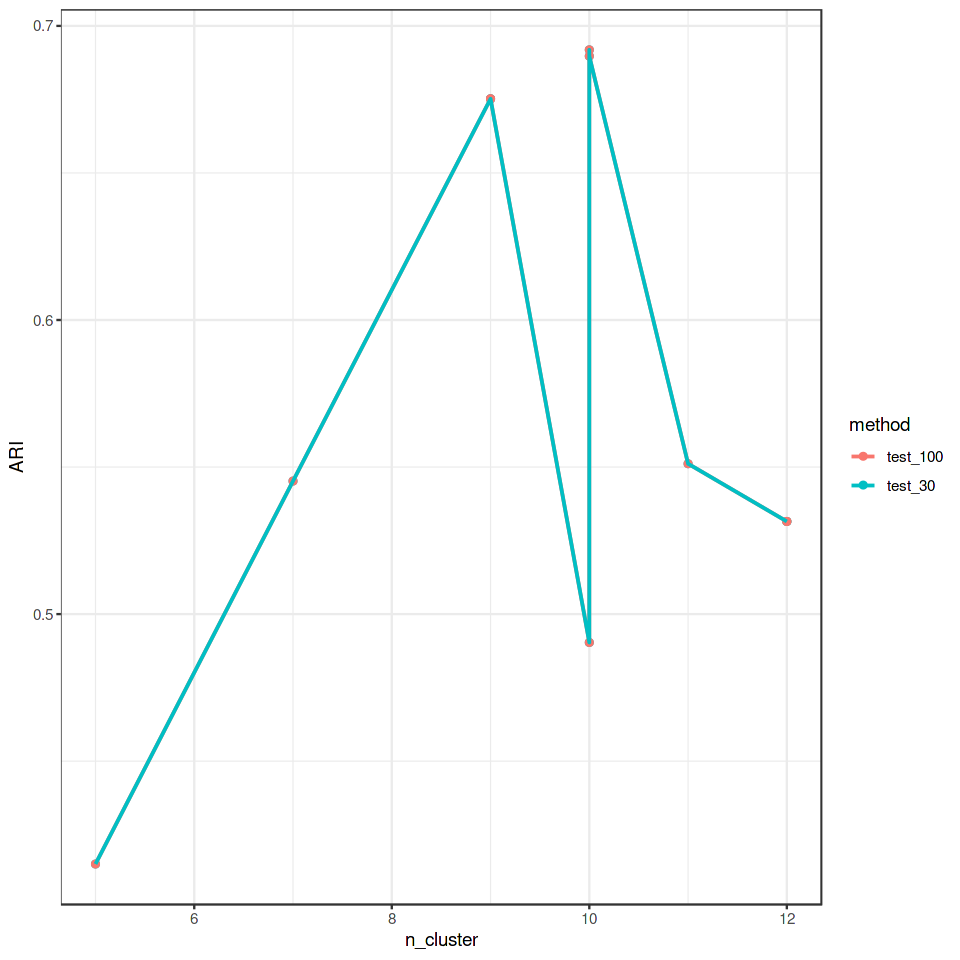

In [18]:
options(repr.plot.width=8, repr.plot.height=8)

df %>% 
  ggplot(aes(x=n_cluster, y=ARI, color=method)) + 
  geom_point(size=1.5) +
  geom_line(size=0.8, aes(x=n_cluster, y=ARI, color=method)) + 
  xlab("n_cluster") +
  ylab("ARI") +
#   geom_vline(xintercept=15, color = "red", linetype = "dashed") +
  theme_bw() #+
  # geom_errorbar(aes(ymin = min_value, ymax = max_value), width = 0.2, linetype = "dashed") +
#   scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)])

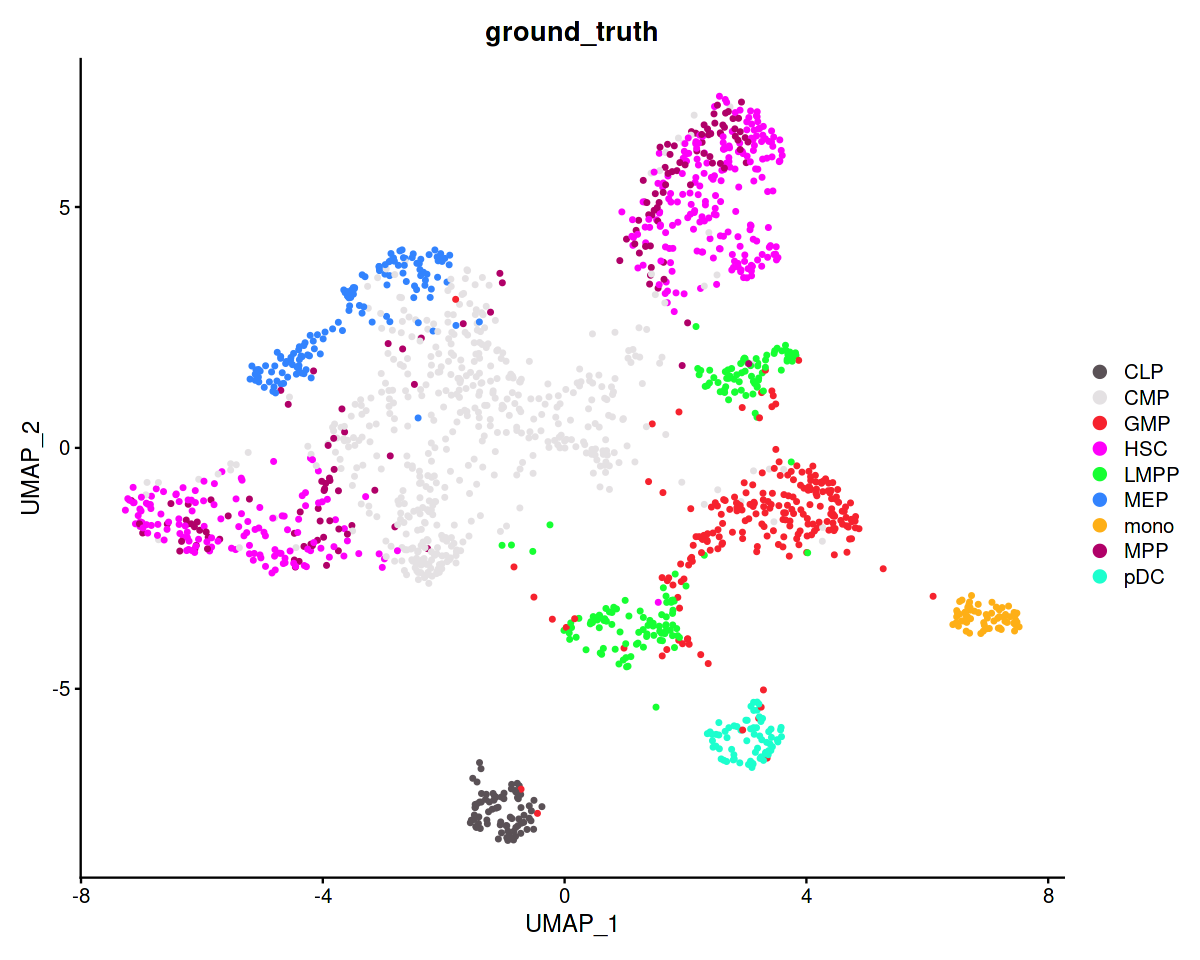

In [19]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")

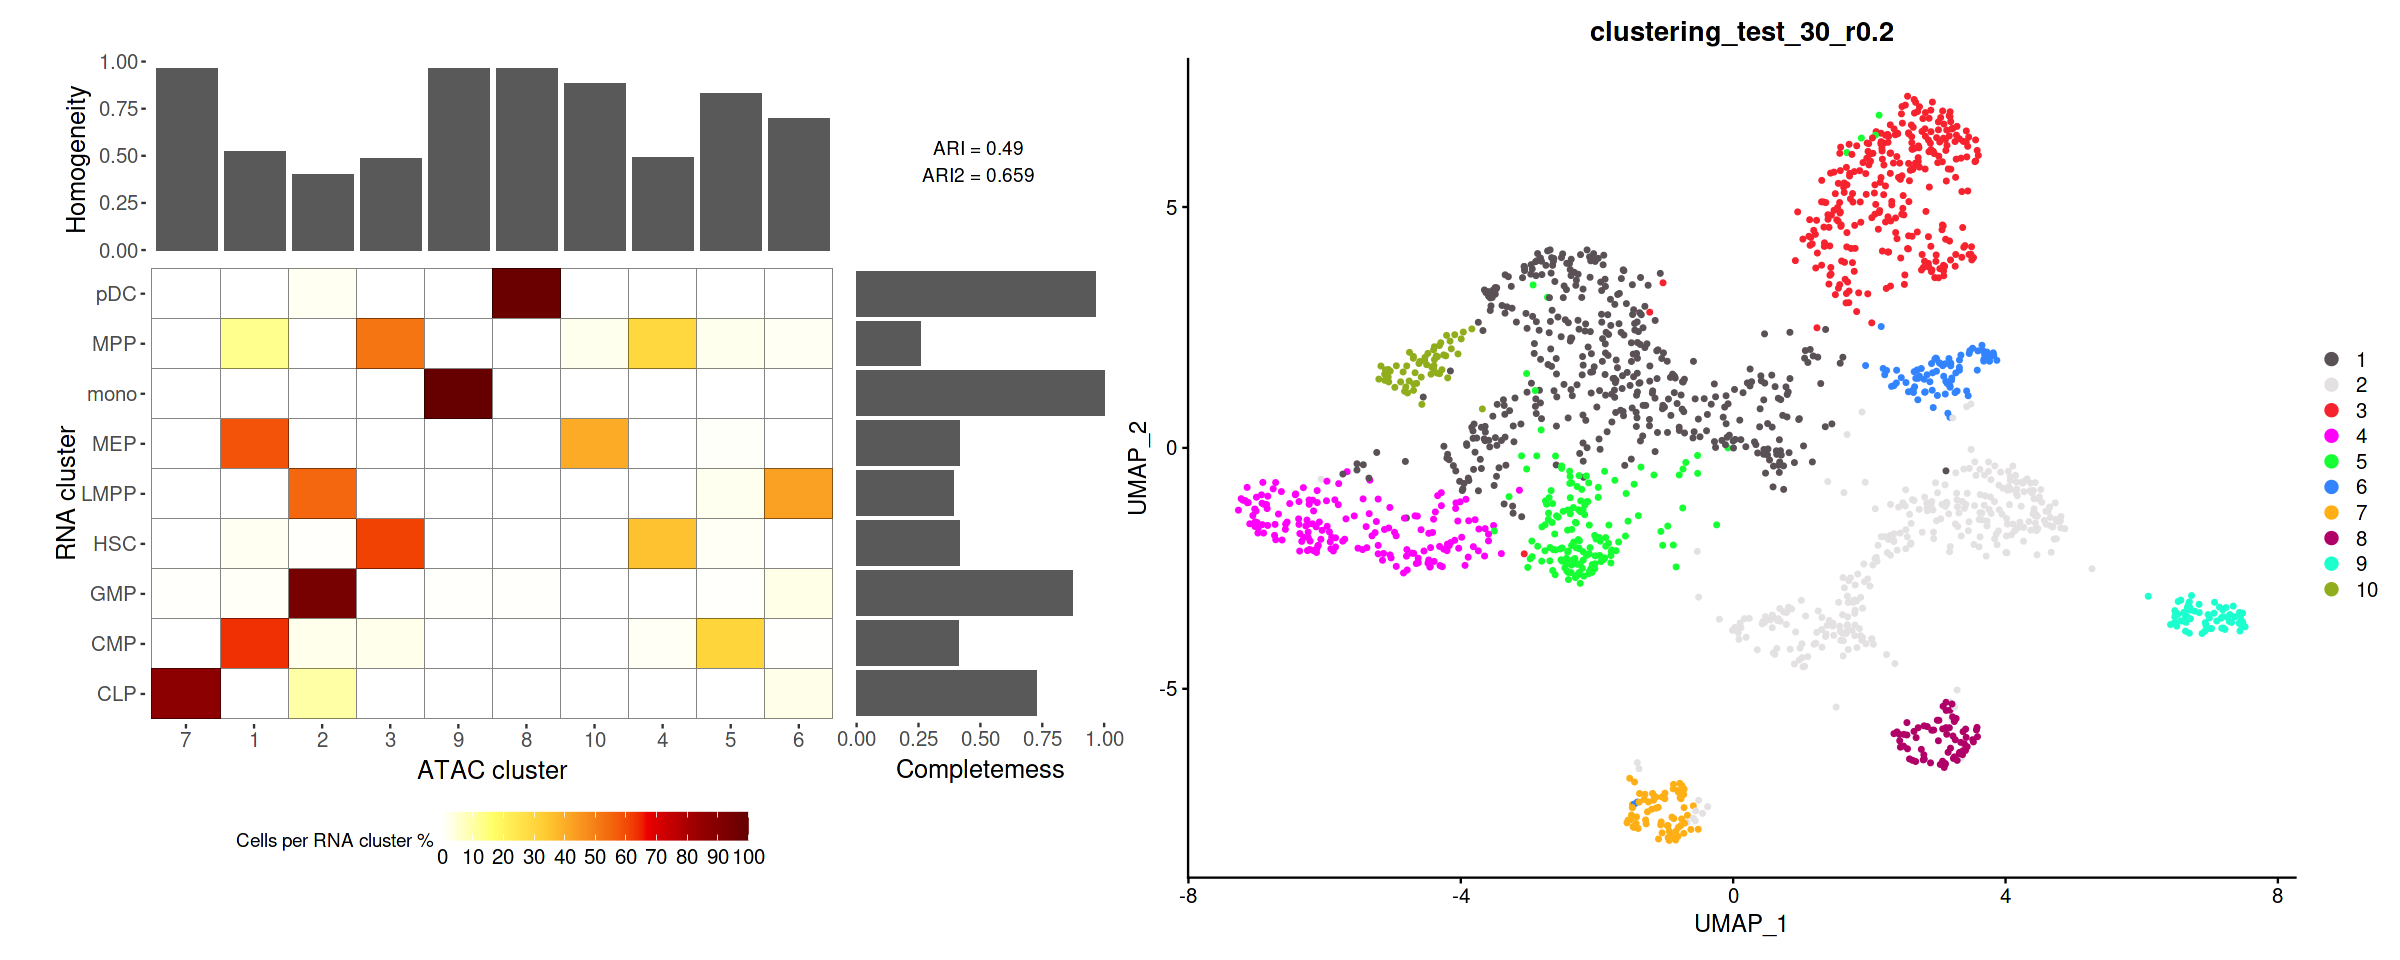

In [20]:
r <- 0.2
embed_name <- "test_30"

options(repr.plot.width=20, repr.plot.height=8)

pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(sobj1$ground_truth, pred, a=1.3, b=1.2, c=2)
p2 <- DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 

p1 + p2

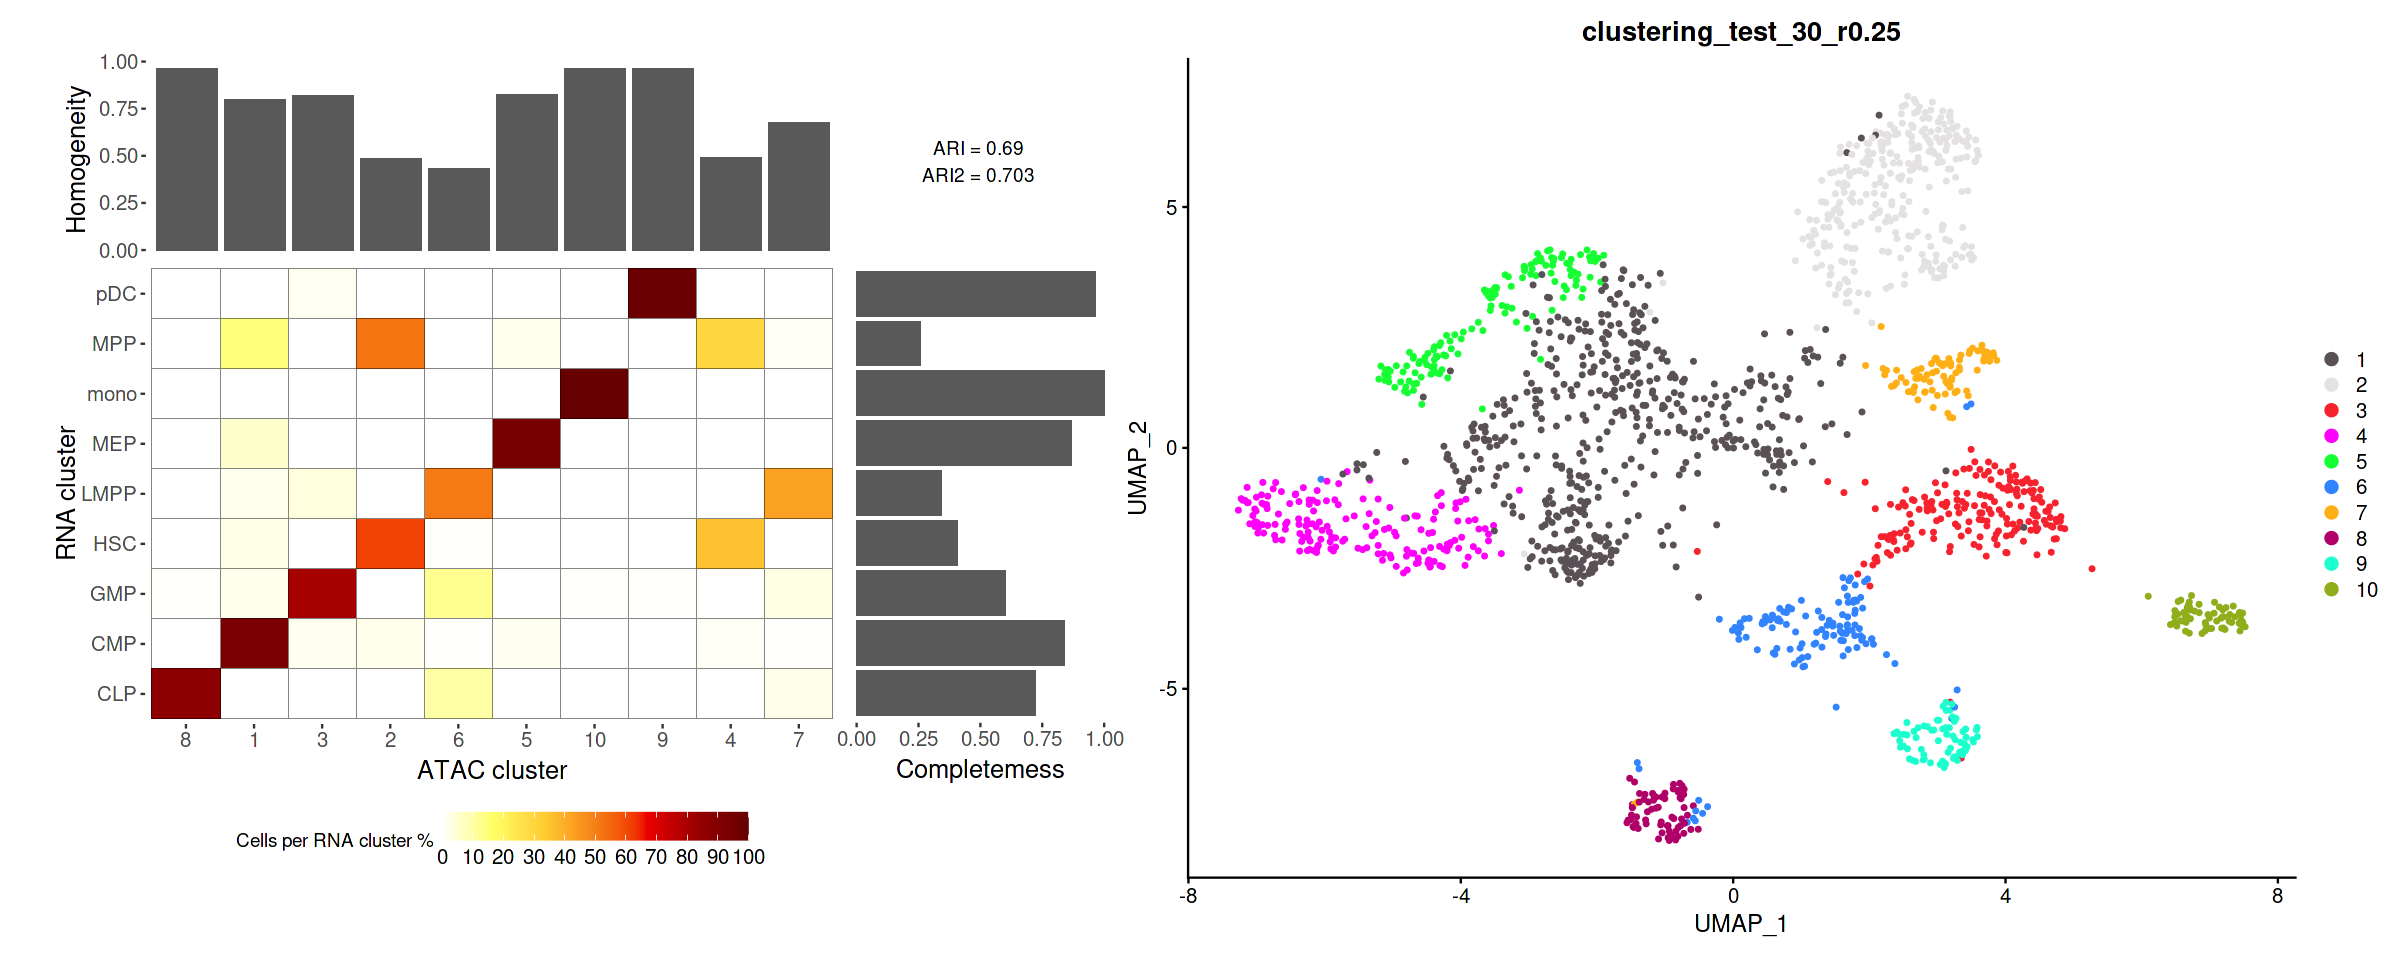

In [21]:
r <- 0.25
embed_name <- "test_30"

options(repr.plot.width=20, repr.plot.height=8)

pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(sobj1$ground_truth, pred, a=1.3, b=1.2, c=2)
p2 <- DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome")  #+ ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 

p1 + p2

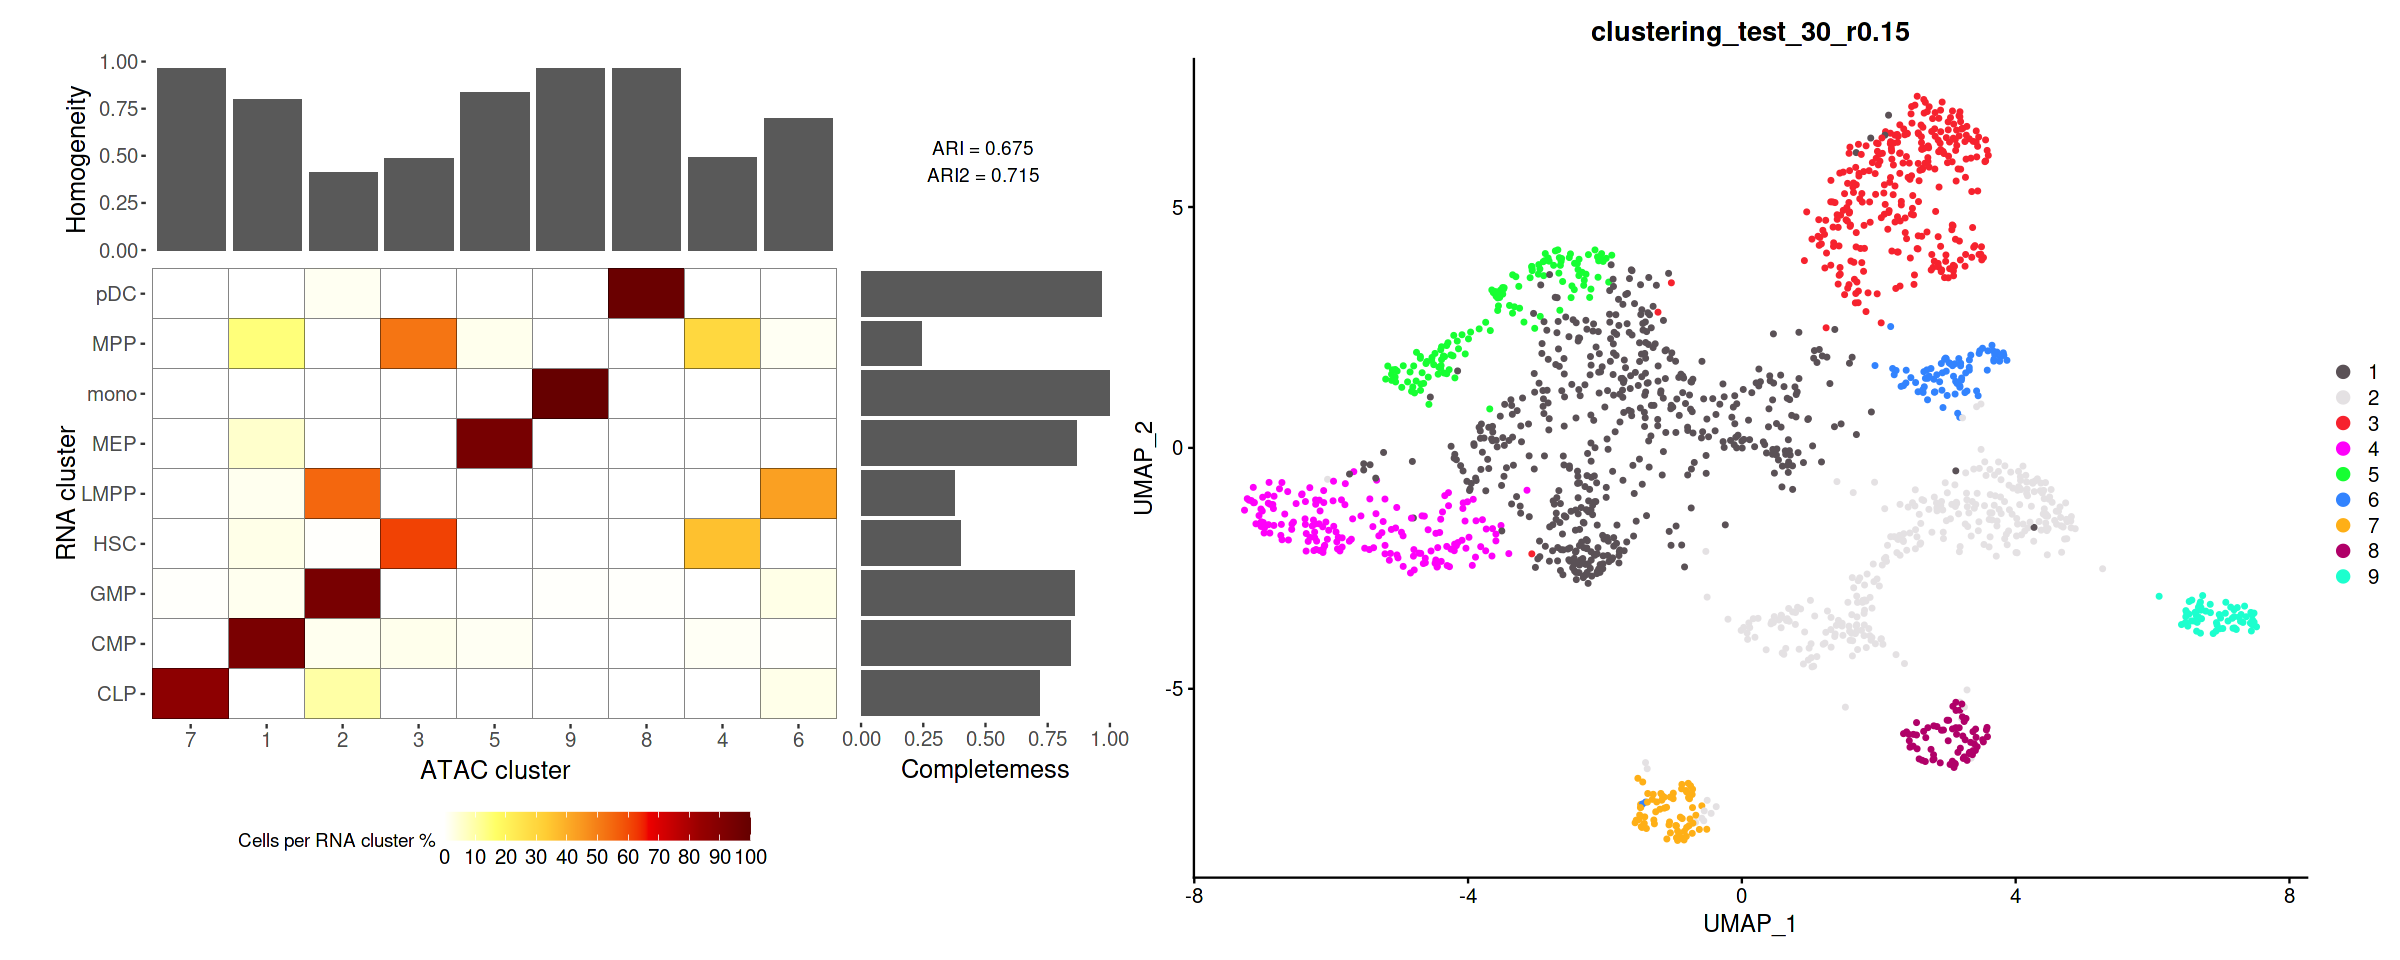

In [42]:
r <- 0.15
embed_name <- "test_30"

options(repr.plot.width=20, repr.plot.height=8)

pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(sobj1$ground_truth, pred, a=1.3, b=1.2, c=2)
p2 <- DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome")  #+ ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 

p1 + p2

### Second run

In [22]:
setwd(paste0("/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/", dataset, "/", dataset))

In [49]:
getwd()

[1] "/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/Buenrostro_2018/Buenrostro_2018"

In [23]:
sobj <- readRDS("clustering/aggregation/default/500/default/30/sobj_SNN.RDS")

embedding_file1 <- "feature_engineering/R/aggregation/default/500/default/30.tsv"
sobj1 <- add_embedding(sobj, embedding_file1, embed_name="test_30", max_dim=30)
embedding_file2 <- "feature_engineering/R/aggregation/default/500/default/100.tsv"
sobj2 <- add_embedding(sobj, embedding_file2, embed_name="test_100", max_dim=100)

Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:100'”


In [24]:
dim(sobj1@reductions[["test_30"]])
dim(sobj2@reductions[["test_100"]])

[1] 1715   30

[1] 1715  100

In [25]:
embed_ls <- c("test_30", "test_100")
r_ls <- c(0.05, 0.1, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3,0.4,0.5)

embed_name <- embed_ls[1]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj1 <- FindNeighbors(object = sobj1, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj1@graphs[[name1]] <- as.Graph(sobj1@graphs[[name1]])
sobj1@graphs[[name2]] <- as.Graph(sobj1@graphs[[name2]])
ndim0 <- dim(sobj1@reductions[[embed_name]])[2]
sobj1 <- RunUMAP(sobj1, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj1 <- FindClusters(object = sobj1, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj1$seurat_clusters
}

embed_name <- embed_ls[2]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj2 <- FindNeighbors(object = sobj2, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj2@graphs[[name1]] <- as.Graph(sobj2@graphs[[name1]])
sobj2@graphs[[name2]] <- as.Graph(sobj2@graphs[[name2]])
ndim0 <- dim(sobj2@reductions[[embed_name]])[2]
sobj2 <- RunUMAP(sobj2, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj2 <- FindClusters(object = sobj2, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj2$seurat_clusters
}


Computing nearest neighbor graph

Computing SNN

20:49:04 UMAP embedding parameters a = 0.9922 b = 1.112

20:49:04 Read 1715 rows and found 30 numeric columns

20:49:04 Using Annoy for neighbor search, n_neighbors = 30

20:49:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:49:04 Writing NN index file to temp file /media/siluo/c55ed6ce-672c-4a68-b60e-cef07edf5933/scratch/Rtmp0A6pzg/file22ea249301f94

20:49:04 Searching Annoy index using 1 thread, search_k = 3000

20:49:05 Annoy recall = 100%

20:49:05 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

20:49:07 Initializing from normalized Laplacian + noise (using irlba)

20:49:07 Commencing optimization for 500 epochs, with 67982 positive edges

20:49:09 Optimization finished


In [28]:
# df <- data.frame(ARI=c(), resolution=c(), method=c(), n_cluster=c())

embed_name <- embed_ls[1]
for(r in r_ls){
pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
ari <- aricode::ARI(sobj1$ground_truth, pred)
# print(embed_name)
# print(ari)
# print(max(as.numeric(unique(pred))))
df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=2))
}   

embed_name <- embed_ls[2]
for(r in r_ls){
pred <- sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
ari <- aricode::ARI(sobj2$ground_truth, pred)
# print(embed_name)
# print(ari)
# print(max(as.numeric(unique(pred))))
df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=2))
}   

In [34]:
df$run <- as.factor(df$run)

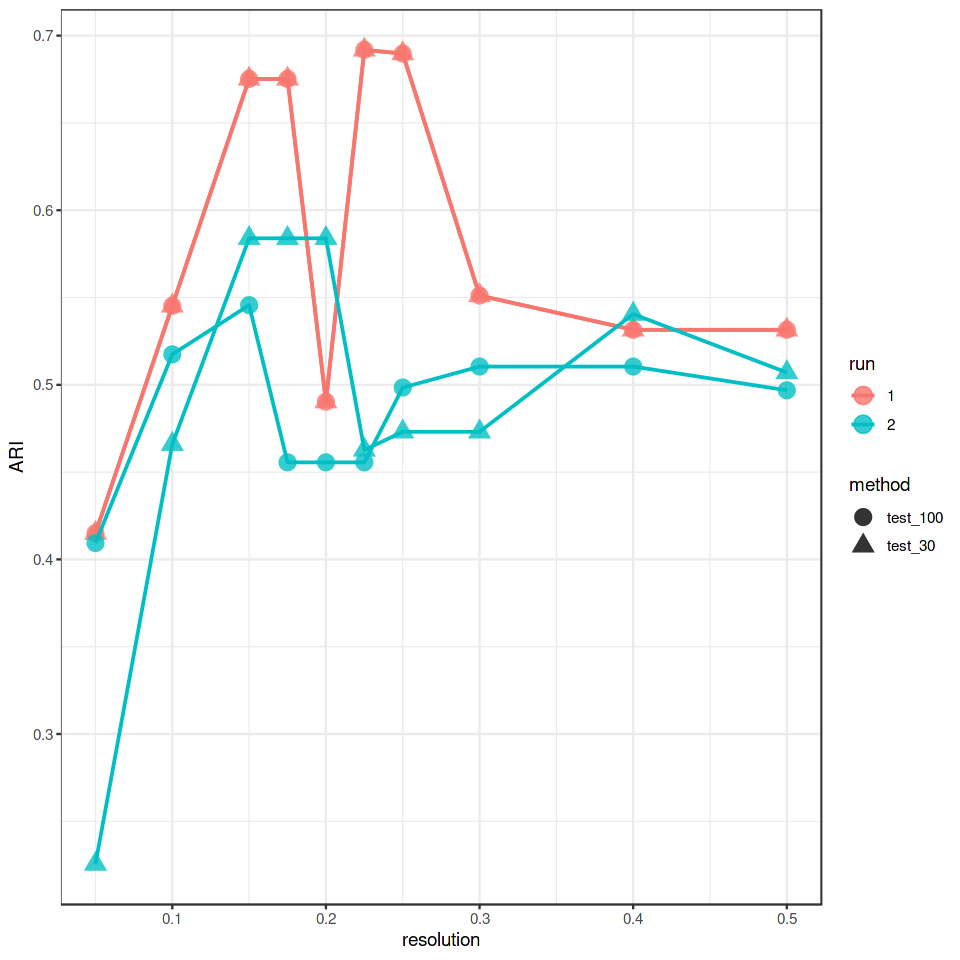

In [42]:
options(repr.plot.width=8, repr.plot.height=8)

df %>% 
  ggplot(aes(x=resolution, y=ARI, color=run, shape = method)) + 
  geom_point(size=4.5, alpha=0.8) +
  geom_line(size=0.8, aes(x=resolution, y=ARI, color=run)) + 
  xlab("resolution") +
  ylab("ARI") +
#   geom_vline(xintercept=15, color = "red", linetype = "dashed") +
  theme_bw() #+
  # geom_errorbar(aes(ymin = min_value, ymax = max_value), width = 0.2, linetype = "dashed") +
#   scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)])

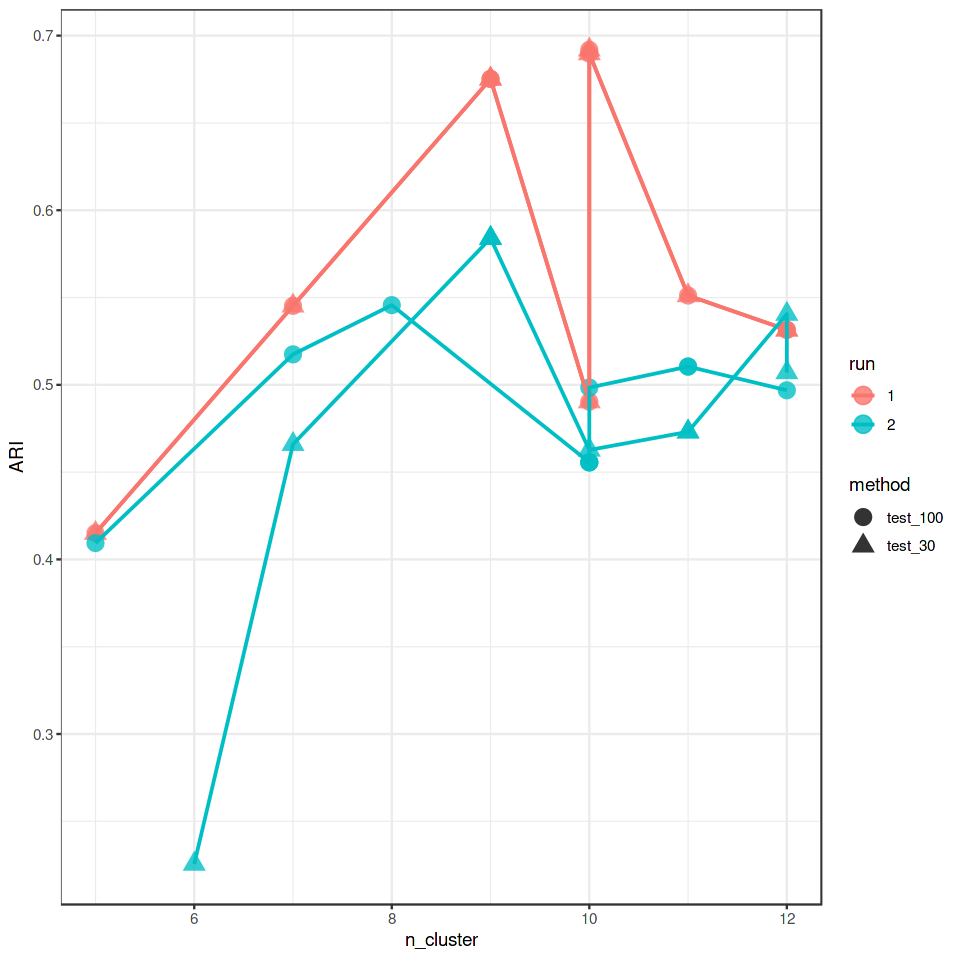

In [43]:
options(repr.plot.width=8, repr.plot.height=8)

df %>% 
  ggplot(aes(x=n_cluster, y=ARI, color=run, shape = method)) + 
  geom_point(size=4.5, alpha=0.8) +
  geom_line(size=0.8, aes(x=n_cluster, y=ARI, color=run)) + 
  xlab("n_cluster") +
  ylab("ARI") +
#   geom_vline(xintercept=15, color = "red", linetype = "dashed") +
  theme_bw() #+
  # geom_errorbar(aes(ymin = min_value, ymax = max_value), width = 0.2, linetype = "dashed") +
#   scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)])

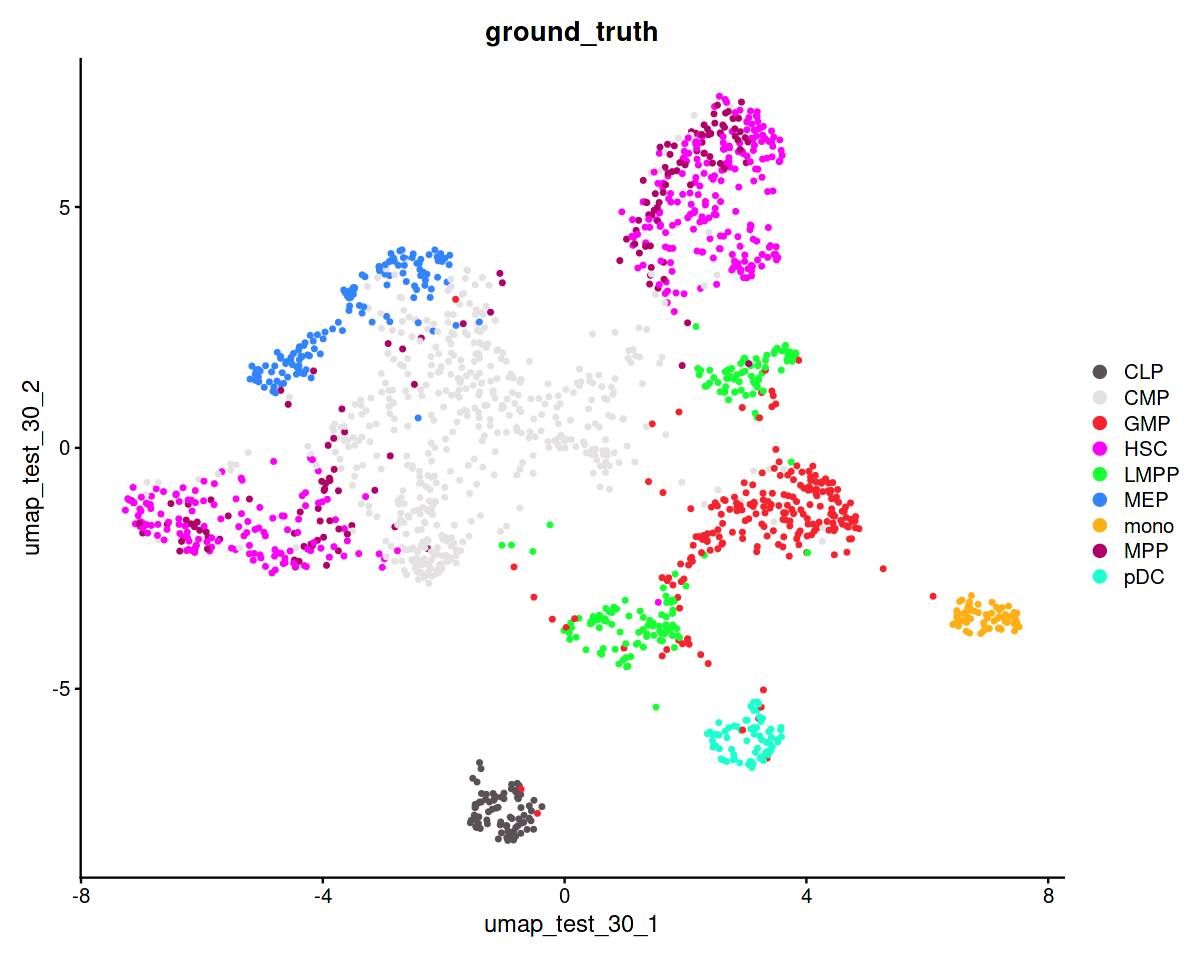

In [61]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(sobj1, reduction = "umap_test_30", label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")

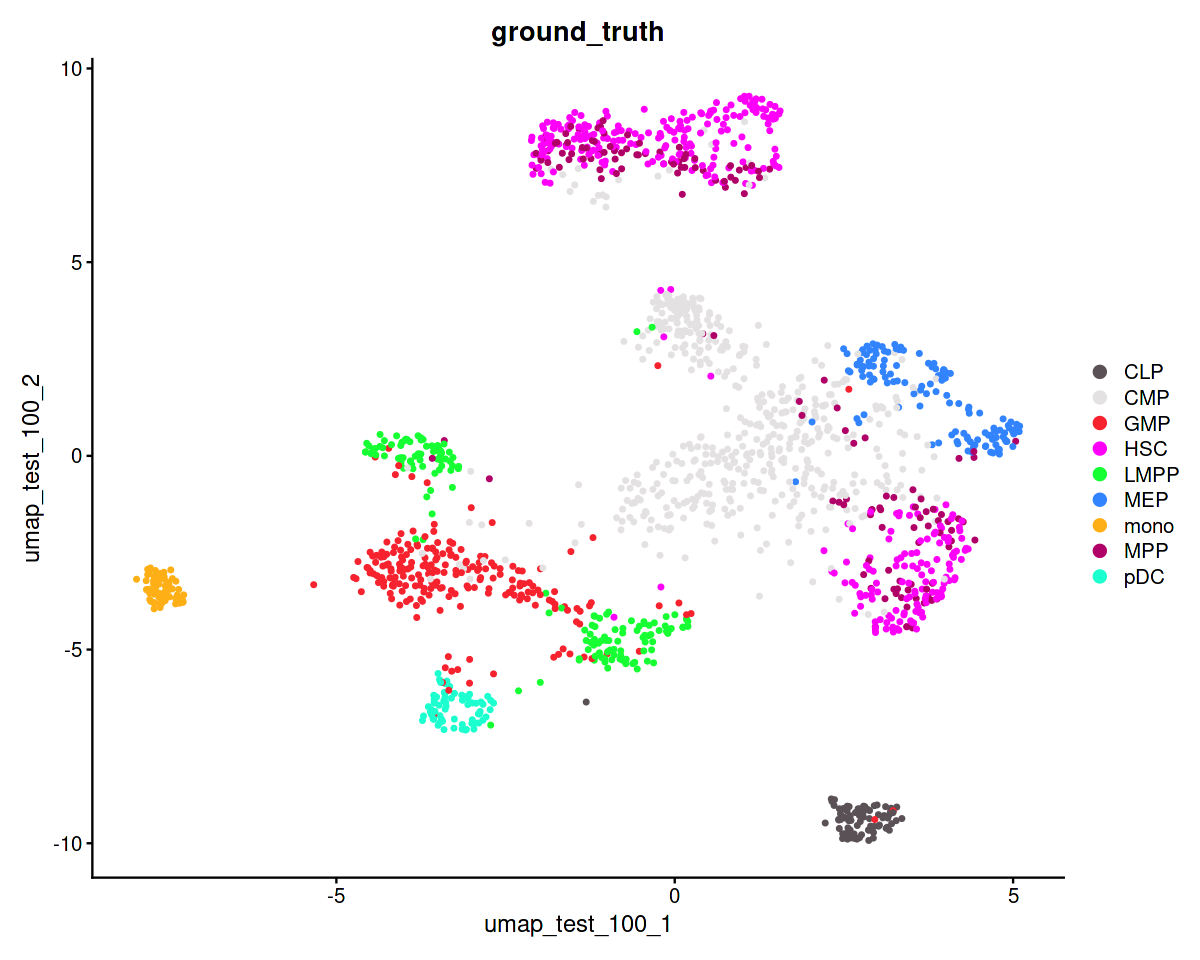

In [60]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(sobj2, reduction = "umap_test_100", label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")

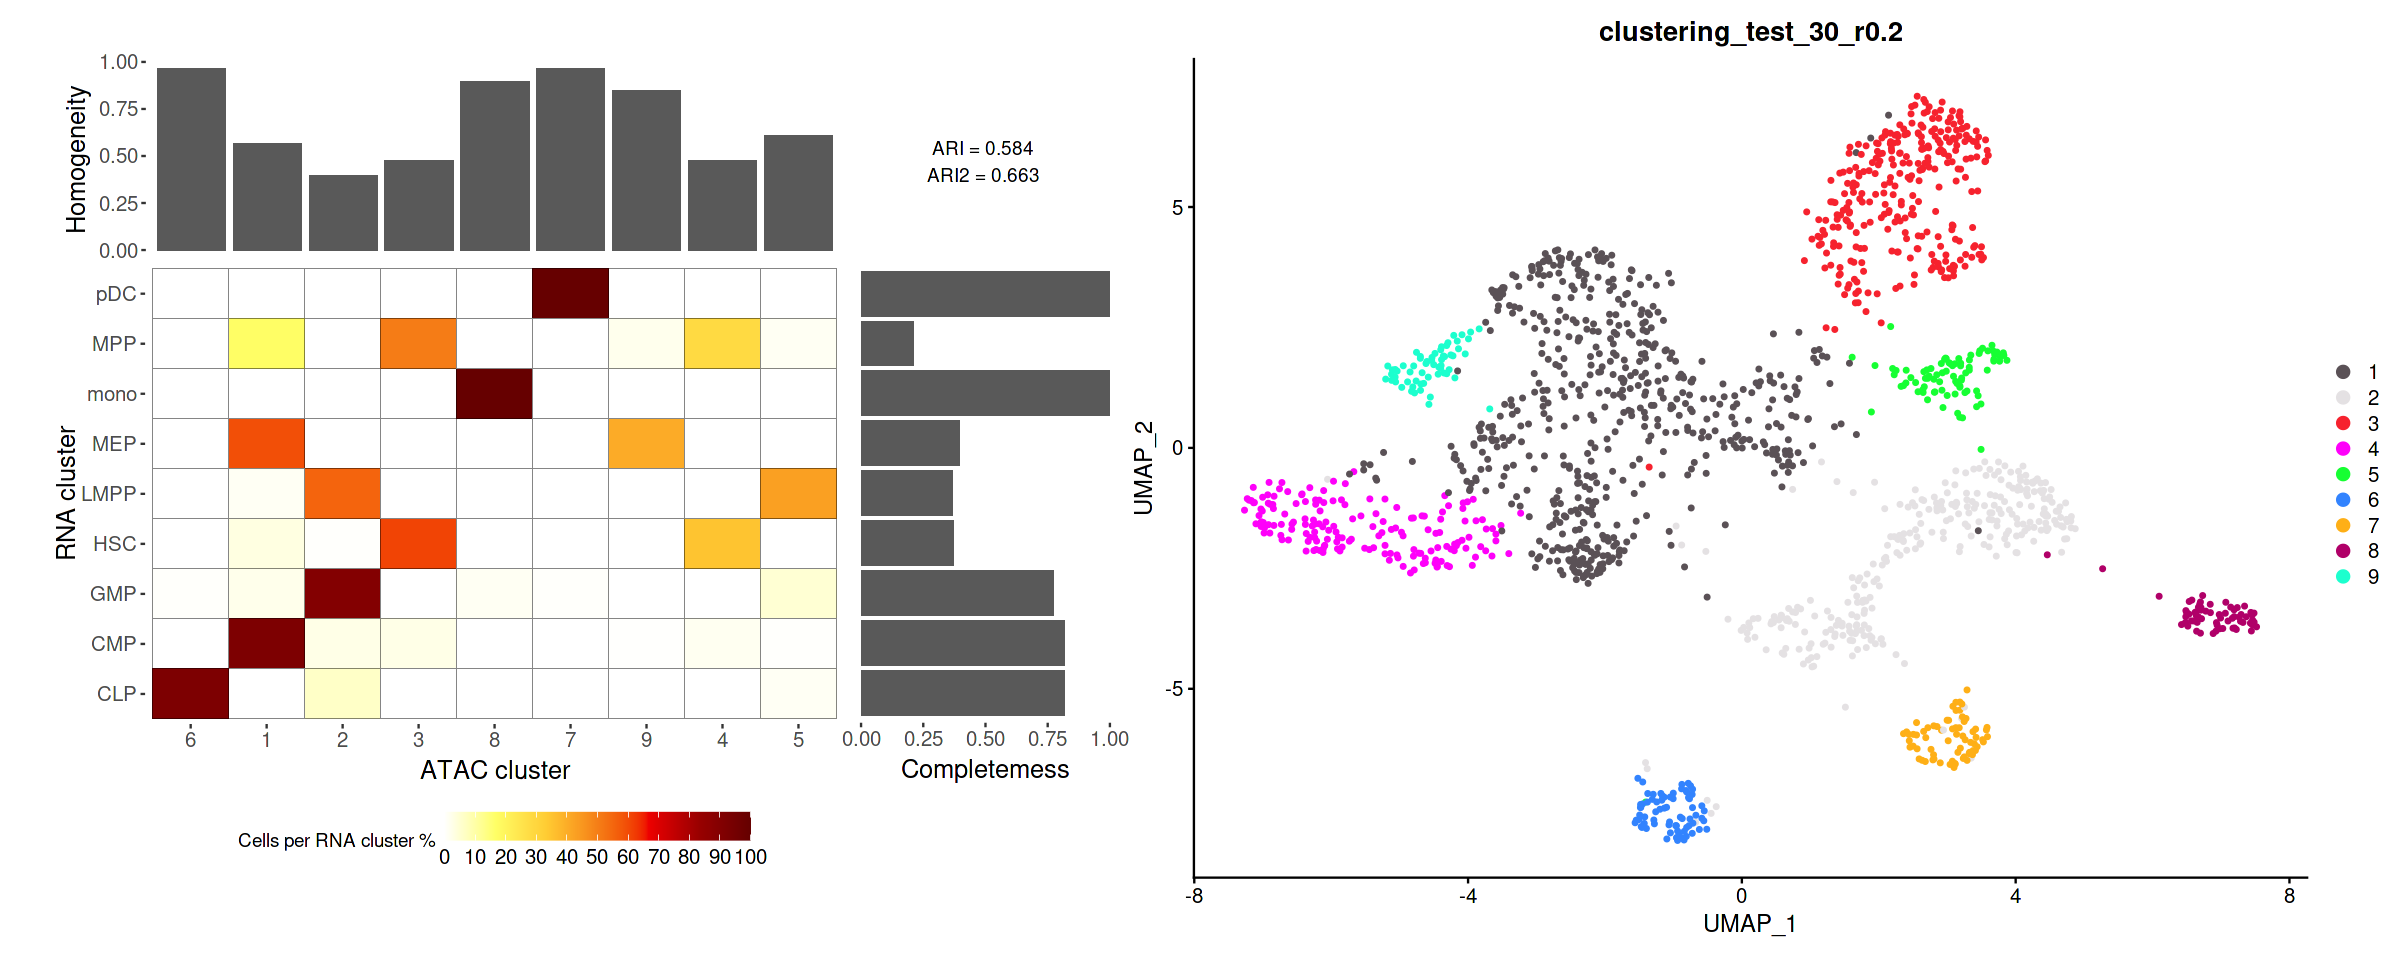

In [62]:
r <- 0.2
embed_name <- "test_30"

options(repr.plot.width=20, repr.plot.height=8)

pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(sobj1$ground_truth, pred, a=1.3, b=1.2, c=2)
p2 <- DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 

p1 + p2

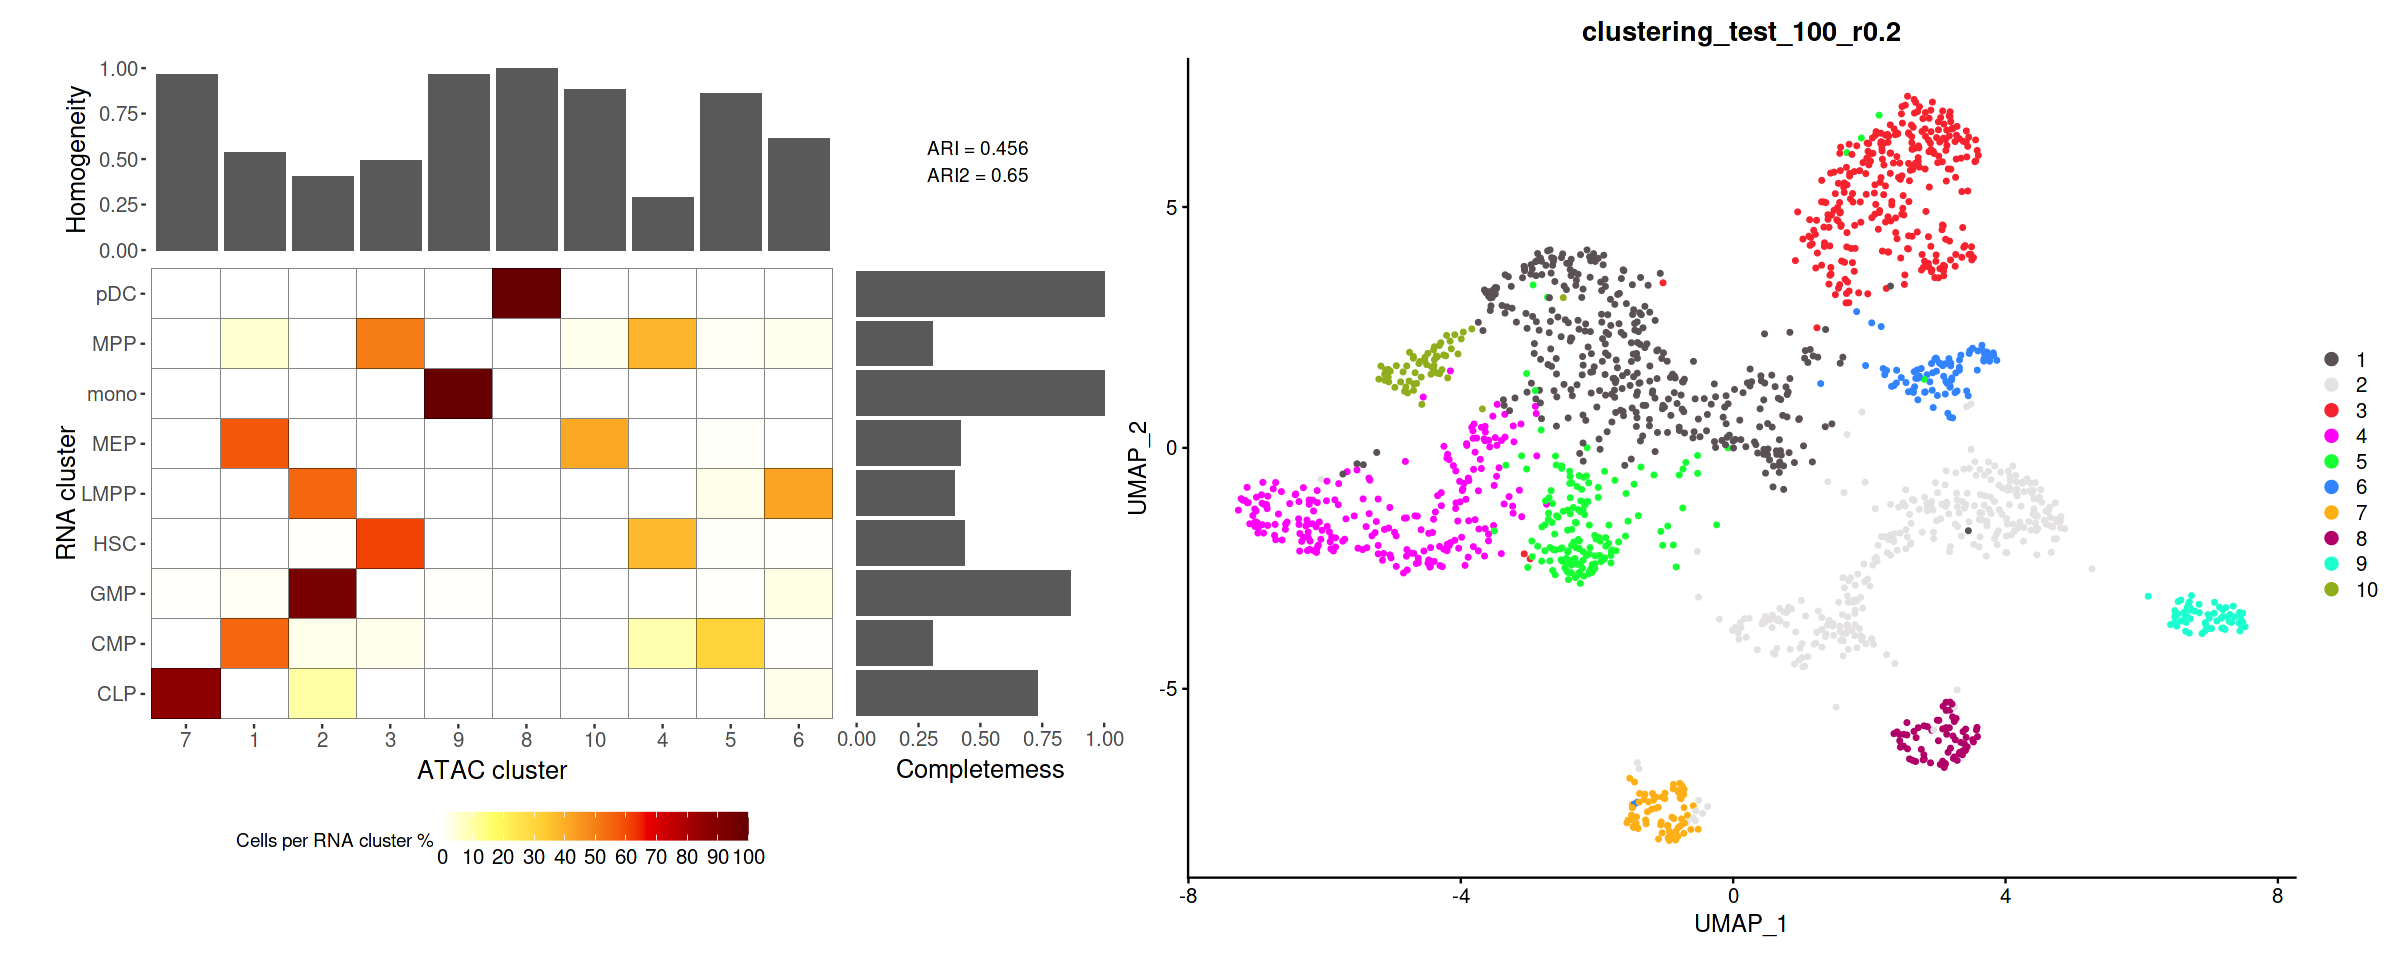

In [63]:
r <- 0.2
embed_name <- "test_100"

options(repr.plot.width=20, repr.plot.height=8)

pred <- sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(sobj2$ground_truth, pred, a=1.3, b=1.2, c=2)
p2 <- DimPlot(sobj2, reduction = "umap", label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 

p1 + p2

### Try for 2 more runs

In [44]:
setwd("~/public/SiyuanLuo/projects/benchmark/scripts/analysis/randomness")

In [45]:
sobj <- readRDS("~/public/SiyuanLuo/projects/benchmark/outputs/Buenrostro_2018/Buenrostro_2018/feature_engineering/R/Signac/by_cluster_peaks/0/default/15.RDS")

In [46]:
feature_matrix <- GetAssayData(sobj[["by_cluster_peaks"]], slot = "counts") # feature-by-cell matrix!
feature_matrix <- t(feature_matrix)

In [7]:
aggregate_features <- function(feature_matrix=NULL, dims, n_meta_features, n_cells, norm_function, reduce, sce=NULL){
    require(SingleCellExperiment)
    require(scDblFinder)
    # feature_matrix: a cell-by-feature matrix
    # first normalize feature_matrix using norm_function, then run PCA (reduce cell dim), then cluster features, 
    # then log-normalize the meta-features, and (optionaly) lastly do dimensional reduction on meta-feature matrix
    if (is.null(feature_matrix) & is.null(sce)){stop("Please specify the feature matrix or sce object as input!")}
    if (is.null(sce)){
        agg_counts <- scDblFinder:::aggregateFeatures(
        t(feature_matrix),
        dims.use = dims,
        k = n_meta_features,
        num_init = 3,
        use.subset = n_cells,
        norm.fn=norm_function, 
        twoPass=TRUE)
    } else {
        sce_x <- scDblFinder:::aggregateFeatures(
        sce,
        dims.use = dims,
        k = n_meta_features,
        num_init = 3,
        use.subset = n_cells,
        norm.fn=norm_function, 
        twoPass=TRUE)

        agg_counts <- counts(sce_x)
        feature_groups <- metadata(sce_x)$featureGroups
    }

    # create sce object
    sce2 <- SingleCellExperiment(list(counts=agg_counts))
    # normalize the meta-features
    sce2 <- scuttle::logNormCounts(sce2)

    if (reduce == "original") {
        Fmat <- t(as.matrix(logcounts(sce2)))
    }else if (reduce == "pca") {
        pca <- scater::runPCA(t(logcounts(sce2)), center=TRUE, scale=TRUE, rank=100)
        Fmat <- as.matrix(pca$x)
    }else if (reduce == 'lsi') {
        tf.idf <- RunTFIDF(object=t(as.matrix(logcounts(sce2))), method=1)
        agg_lsi <- RunSVD(t(tf.idf), n = 100, scale.embeddings = TRUE)
        Fmat <- agg_lsi
    }else{stop("Please specify correct dimensional reduction method!")}

    if (is.null(sce)){
        return(Fmat)
        } else {
            return(list(Fmat=Fmat, Fgrp=feature_groups))
            }
}


In [8]:
DepthCorComponents <- function(embed, counts, corCutOff, n){
	depth.cor <- as.data.frame(cor(x = embed, y = counts))
	# depth.cor$counts <- depth.cor[, 1]
	# depth.cor$Component <- seq_len(length.out = nrow(x = depth.cor))
	component.keep <- !abs(depth.cor) >= corCutOff
	return(seq_len(length.out = n)[component.keep])
}

In [49]:
dims=seq(2L, 12L)
n_meta_features=1000
n_cells=2000 
norm_method='tfidf' 
reduce="pca"
ndim=100
norm_function <- Signac::RunTFIDF

embed <- aggregate_features(feature_matrix=feature_matrix, dims=dims, n_meta_features=n_meta_features, n_cells=n_cells, norm_function=norm_function, reduce=reduce, sce=NULL)
counts <- Matrix::rowSums(feature_matrix)
embed <- embed[, seq_len(length.out = ndim)]
components <- DepthCorComponents(embed, counts, 0.75, ndim)
agg_feature_matrix <- embed[, components]

Loading required package: scDblFinder

Performing TF-IDF normalization



In [50]:
# write.table(agg_feature_matrix, file = "Buenrostro_2018_Agg_ndim100.tsv", sep = "\t", quote = FALSE, col.names = FALSE)
write.table(agg_feature_matrix, file = "Buenrostro_2018_Agg_ndim100.2.tsv", sep = "\t", quote = FALSE, col.names = FALSE)

In [54]:
sobj <- readRDS("~/public/SiyuanLuo/projects/benchmark/outputs/Buenrostro_2018/Buenrostro_2018/clustering/aggregation/default/500/default/30/sobj_SNN.RDS")

embedding_file <- "Agg_ndim100.tsv"
sobj1 <- add_embedding(sobj, embedding_file, embed_name="run3_ndim30", max_dim=30)
sobj2 <- add_embedding(sobj, embedding_file, embed_name="run3_ndim100", max_dim=100)

embedding_file <- "Agg_ndim100.2.tsv"
sobj1 <- add_embedding(sobj1, embedding_file, embed_name="run4_ndim30", max_dim=30)
sobj2 <- add_embedding(sobj2, embedding_file, embed_name="run4_ndim100", max_dim=100)

Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:100'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:100'”


In [63]:
embed_ls <- c("run3_ndim30", "run3_ndim100","run4_ndim30", "run4_ndim100")
r_ls <- c(0.05, 0.1, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3,0.4,0.5)

embed_name <- embed_ls[1]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj1 <- FindNeighbors(object = sobj1, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj1@graphs[[name1]] <- as.Graph(sobj1@graphs[[name1]])
sobj1@graphs[[name2]] <- as.Graph(sobj1@graphs[[name2]])
ndim0 <- dim(sobj1@reductions[[embed_name]])[2]
sobj1 <- RunUMAP(sobj1, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj1 <- FindClusters(object = sobj1, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj1$seurat_clusters
}

embed_name <- embed_ls[2]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj2 <- FindNeighbors(object = sobj2, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj2@graphs[[name1]] <- as.Graph(sobj2@graphs[[name1]])
sobj2@graphs[[name2]] <- as.Graph(sobj2@graphs[[name2]])
ndim0 <- dim(sobj2@reductions[[embed_name]])[2]
sobj2 <- RunUMAP(sobj2, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj2 <- FindClusters(object = sobj2, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj2$seurat_clusters
}

embed_name <- embed_ls[3]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj1 <- FindNeighbors(object = sobj1, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj1@graphs[[name1]] <- as.Graph(sobj1@graphs[[name1]])
sobj1@graphs[[name2]] <- as.Graph(sobj1@graphs[[name2]])
ndim0 <- dim(sobj1@reductions[[embed_name]])[2]
sobj1 <- RunUMAP(sobj1, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj1 <- FindClusters(object = sobj1, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj1$seurat_clusters
}

embed_name <- embed_ls[4]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj2 <- FindNeighbors(object = sobj2, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj2@graphs[[name1]] <- as.Graph(sobj2@graphs[[name1]])
sobj2@graphs[[name2]] <- as.Graph(sobj2@graphs[[name2]])
ndim0 <- dim(sobj2@reductions[[embed_name]])[2]
sobj2 <- RunUMAP(sobj2, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj2 <- FindClusters(object = sobj2, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj2$seurat_clusters
}

Computing nearest neighbor graph

Computing SNN

21:06:25 UMAP embedding parameters a = 0.9922 b = 1.112

21:06:25 Read 1715 rows and found 30 numeric columns

21:06:25 Using Annoy for neighbor search, n_neighbors = 30

21:06:25 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:06:25 Writing NN index file to temp file /media/siluo/c55ed6ce-672c-4a68-b60e-cef07edf5933/scratch/Rtmp0A6pzg/file22ea2264b8204

21:06:25 Searching Annoy index using 1 thread, search_k = 3000

21:06:25 Annoy recall = 100%

21:06:26 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:06:28 Initializing from normalized Laplacian + noise (using irlba)

21:06:28 Commencing optimization for 500 epochs, with 68050 positive edges

21:06:31 Optimization finished


In [64]:
df$run <- as.numeric(df$run)

In [66]:
# df <- data.frame(ARI=c(), resolution=c(), method=c(), n_cluster=c())

embed_name <- embed_ls[1]
for(r in r_ls){
    pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
    ari <- aricode::ARI(sobj1$ground_truth, pred)
    # print(embed_name)
    # print(ari)
    # print(max(as.numeric(unique(pred))))
    df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=3))
}   

embed_name <- embed_ls[2]
for(r in r_ls){
    pred <- sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
    ari <- aricode::ARI(sobj2$ground_truth, pred)
    # print(embed_name)
    # print(ari)
    # print(max(as.numeric(unique(pred))))
    df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=3))
}   

embed_name <- embed_ls[3]
for(r in r_ls){
    pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
    ari <- aricode::ARI(sobj1$ground_truth, pred)
    # print(embed_name)
    # print(ari)
    # print(max(as.numeric(unique(pred))))
    df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=4))
}   

embed_name <- embed_ls[4]
for(r in r_ls){
    pred <- sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
    ari <- aricode::ARI(sobj2$ground_truth, pred)
    # print(embed_name)
    # print(ari)
    # print(max(as.numeric(unique(pred))))
    df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=4))
}

In [67]:
df$run <- as.factor(df$run)

In [73]:
df[grepl("30", df$method), "method"] <- "ndim30"
df[grepl("100", df$method), "method"] <- "ndim100"

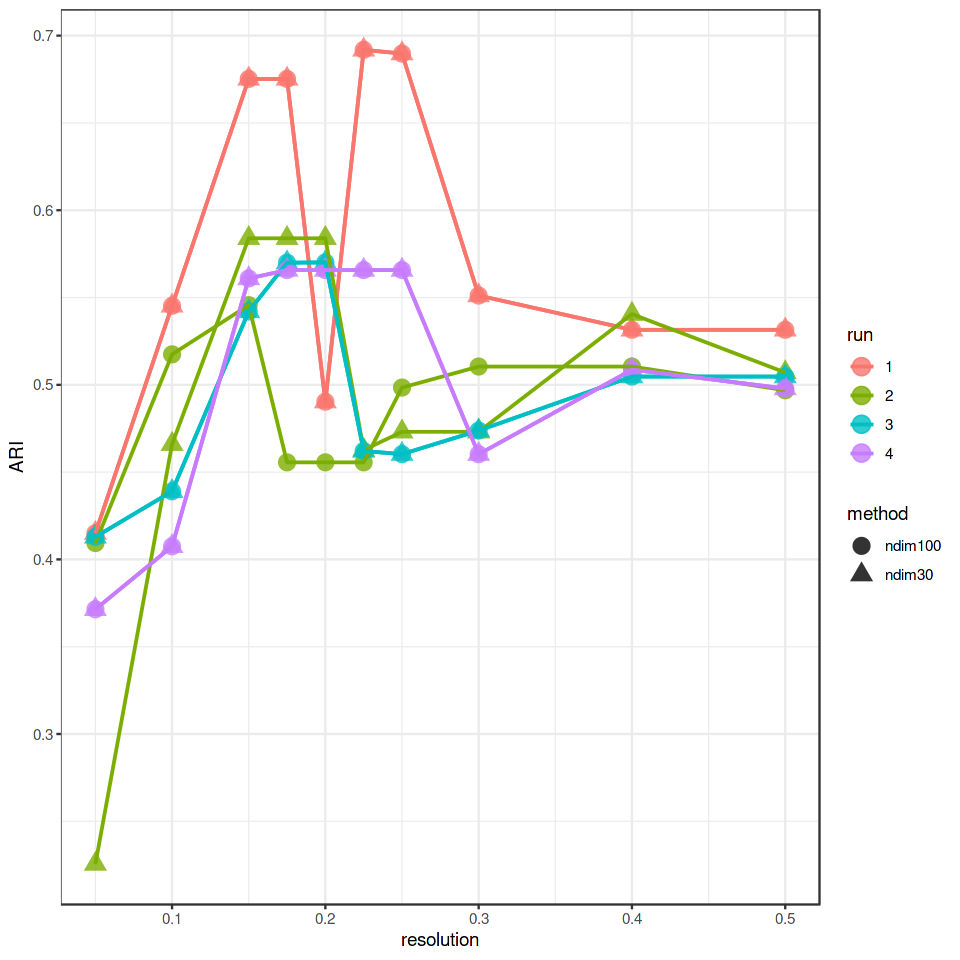

In [74]:
options(repr.plot.width=8, repr.plot.height=8)

df %>% 
  ggplot(aes(x=resolution, y=ARI, color=run, shape = method)) + 
  geom_point(size=4.5, alpha=0.8) +
  geom_line(size=0.8, aes(x=resolution, y=ARI, color=run)) + 
  xlab("resolution") +
  ylab("ARI") +
#   geom_vline(xintercept=15, color = "red", linetype = "dashed") +
  theme_bw() #+
  # geom_errorbar(aes(ymin = min_value, ymax = max_value), width = 0.2, linetype = "dashed") +
#   scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)])

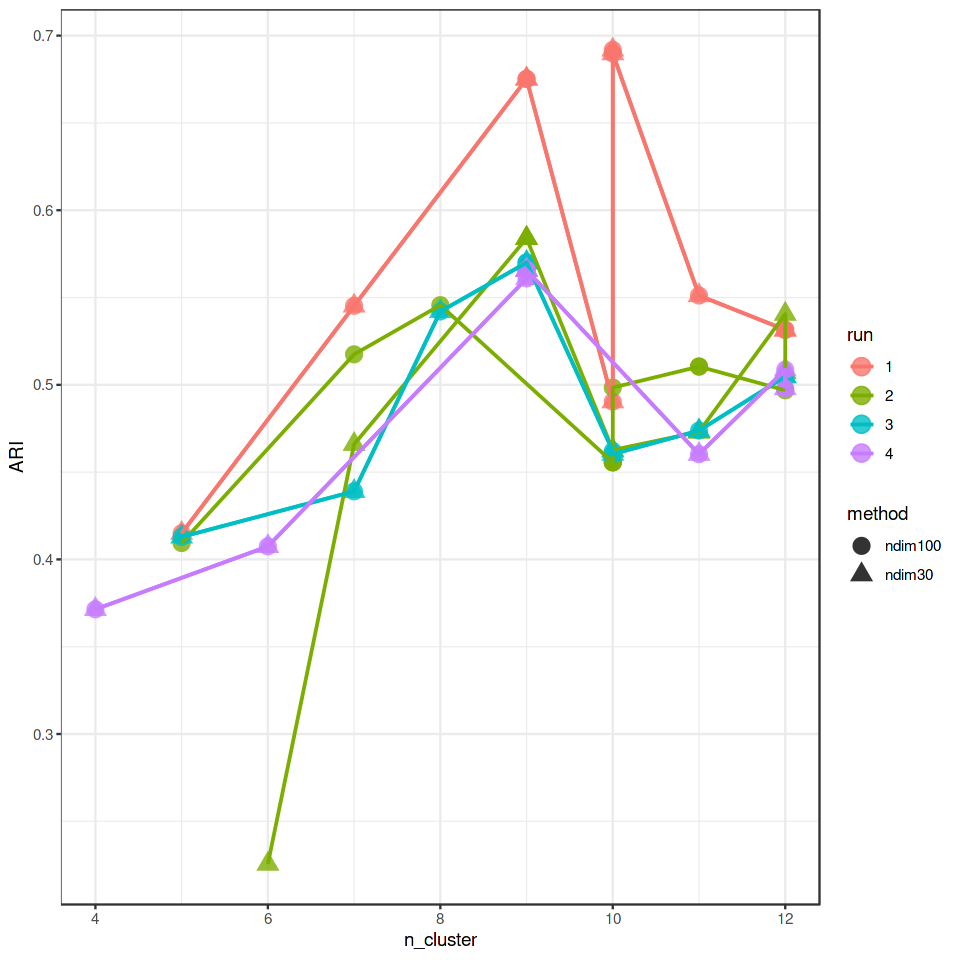

In [75]:
options(repr.plot.width=8, repr.plot.height=8)

df %>% 
  ggplot(aes(x=n_cluster, y=ARI, color=run, shape = method)) + 
  geom_point(size=4.5, alpha=0.8) +
  geom_line(size=0.8, aes(x=n_cluster, y=ARI, color=run)) + 
  xlab("n_cluster") +
  ylab("ARI") +
#   geom_vline(xintercept=15, color = "red", linetype = "dashed") +
  theme_bw() #+
  # geom_errorbar(aes(ymin = min_value, ymax = max_value), width = 0.2, linetype = "dashed") +
#   scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)])

In [77]:
getwd()

[1] "/home/siluo/public/SiyuanLuo/projects/benchmark/scripts/analysis/randomness"

In [79]:
write.table(df, "agg_randomness_Buenrostro_2018.tsv", sep="\t", quote = FALSE,)

# PBMC

In [8]:
i <- 5
dataset <- dataset_ls[i]
k_optimal <- k_ls[i]

In [9]:
setwd(paste0("/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/", dataset))
df <- read.table(file="meta_info_for_evaluation.tsv", sep="\t", header=TRUE)
df_metrics <- read.table(file="metrics_value.tsv", sep="\t", header=TRUE)

In [10]:
setwd(paste0("/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/", dataset, "/", dataset))

### First run

In [11]:
embedding_file <- "feature_engineering/R/aggregation/default/500/default/100.tsv"
sobj <- readRDS("clustering/aggregation/default/500/default/30/sobj_SNN.RDS")
sobj1 <- add_embedding(sobj, embedding_file, embed_name="ndim30", max_dim=30)
sobj2 <- add_embedding(sobj, embedding_file, embed_name="ndim100", max_dim=100)

Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:100'”


In [12]:
embed_ls <- c("ndim30", "ndim100")
r_ls <- c(0.05, 0.1, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3, 0.35, 0.4, 0.5)

embed_name <- embed_ls[1]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj1 <- FindNeighbors(object = sobj1, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj1@graphs[[name1]] <- as.Graph(sobj1@graphs[[name1]])
sobj1@graphs[[name2]] <- as.Graph(sobj1@graphs[[name2]])
ndim0 <- dim(sobj1@reductions[[embed_name]])[2]
sobj1 <- RunUMAP(sobj1, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj1 <- FindClusters(object = sobj1, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj1$seurat_clusters
}

embed_name <- embed_ls[2]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj2 <- FindNeighbors(object = sobj2, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj2@graphs[[name1]] <- as.Graph(sobj2@graphs[[name1]])
sobj2@graphs[[name2]] <- as.Graph(sobj2@graphs[[name2]])
ndim0 <- dim(sobj2@reductions[[embed_name]])[2]
sobj2 <- RunUMAP(sobj2, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj2 <- FindClusters(object = sobj2, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj2$seurat_clusters
}


Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
09:52:52 UMAP embedding parameters a = 0.9922 b = 1.112

09:52:52 Read 8560 rows and found 30 numeric columns

09:52:52 Using Annoy for neighbor search, n_neighbors = 30

09:52:52 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:52:53 Writing NN index file to temp file /media/siluo/c55ed6ce-672c-4a68-b60e-cef07edf5933/scratch/Rtmptniefo/file248603c2828a3

09:52:53 Searching Annoy index using 1 thread, search_k = 3000

09:52:55 Annoy recal

In [13]:
df <- data.frame(ARI=c(), resolution=c(), method=c(), n_cluster=c())

embed_name <- embed_ls[1]
for(r in r_ls){
pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
ari <- aricode::ARI(sobj1$ground_truth, pred)
# print(embed_name)
# print(ari)
# print(max(as.numeric(unique(pred))))
df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred)))))
}   

embed_name <- embed_ls[2]
for(r in r_ls){
pred <- sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
ari <- aricode::ARI(sobj2$ground_truth, pred)
# print(embed_name)
# print(ari)
# print(max(as.numeric(unique(pred))))
df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred)))))
}   
df$run <- 1

In [14]:
df

ARI       resolution method  n_cluster run
1  0.6360393 0.050      ndim30   7        1  
2  0.6555336 0.100      ndim30   9        1  
3  0.6614235 0.150      ndim30  10        1  
4  0.6616332 0.175      ndim30  10        1  
5  0.6744229 0.200      ndim30  11        1  
6  0.6744229 0.225      ndim30  11        1  
7  0.6777039 0.250      ndim30  11        1  
8  0.6392752 0.300      ndim30  10        1  
9  0.6773810 0.350      ndim30  11        1  
10 0.6473121 0.400      ndim30  11        1  
11 0.6161304 0.500      ndim30  13        1  
12 0.6360393 0.050      ndim100  7        1  
13 0.6555336 0.100      ndim100  9        1  
14 0.6614235 0.150      ndim100 10        1  
15 0.6616332 0.175      ndim100 10        1  
16 0.6744229 0.200      ndim100 11        1  
17 0.6744229 0.225      ndim100 11        1  
18 0.6777039 0.250      ndim100 11        1  
19 0.6392752 0.300      ndim100 10        1  
20 0.6773810 0.350      ndim100 11        1  
21 0.6473121 0.400      ndim100 11        1  
22 0.6161304 0.500      ndim100 13        1

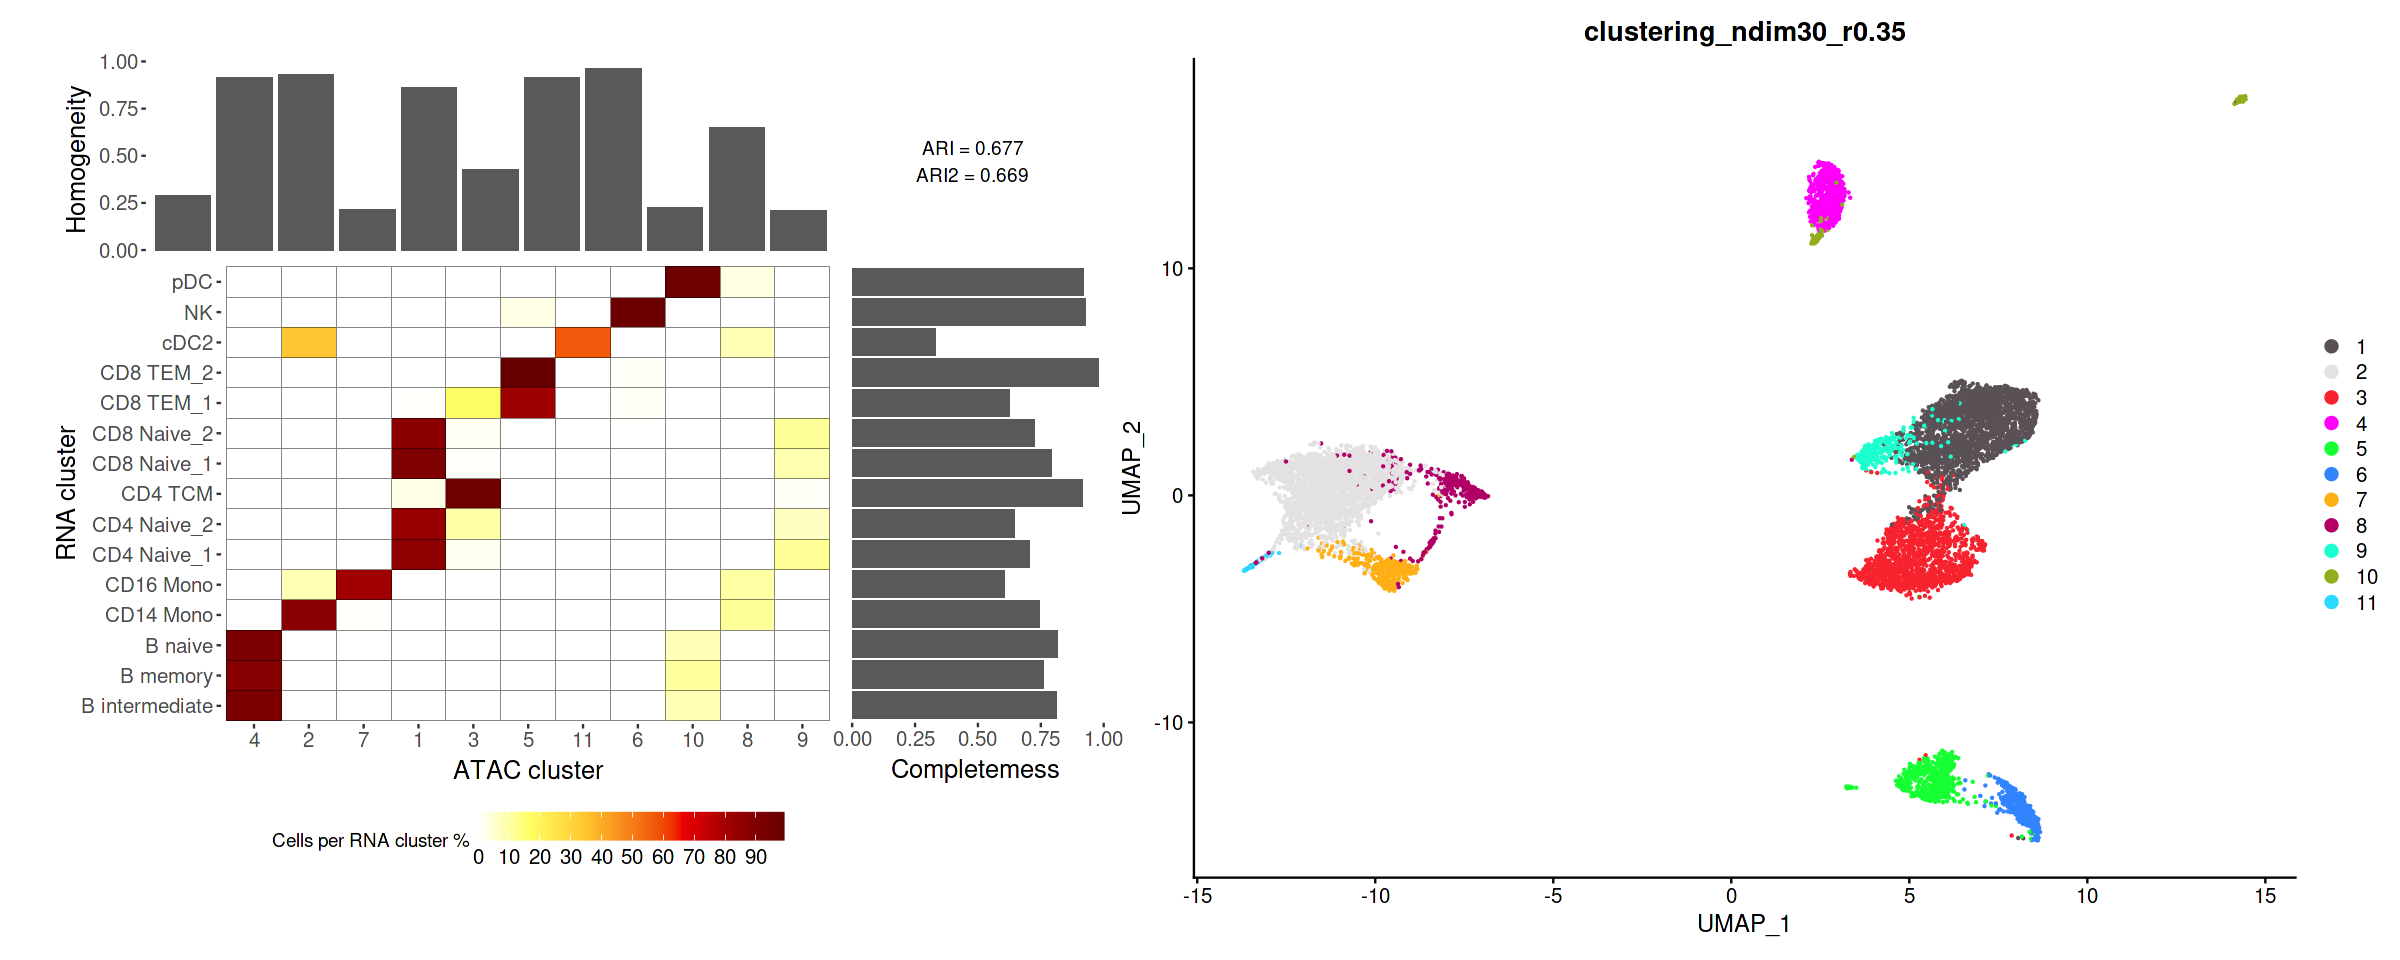

In [96]:
r <- 0.35
embed_name <- "ndim30"

options(repr.plot.width=20, repr.plot.height=8)

pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(sobj1$ground_truth, pred, a=1.3, b=1.2, c=2)
p2 <- DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 

p1 + p2

## Try more run

In [10]:
setwd("~/public/SiyuanLuo/projects/benchmark/scripts/analysis/randomness")
sobj <- readRDS("~/public/SiyuanLuo/projects/benchmark/outputs/PBMC_multiomics/PBMC_multiomics/feature_engineering/R/Signac/by_cluster_peaks/0/default/15.RDS")
feature_matrix <- GetAssayData(sobj[["by_cluster_peaks"]], slot = "counts") # feature-by-cell matrix!
feature_matrix <- t(feature_matrix)

Loading required package: Signac



In [16]:
dims=seq(2L, 12L)
n_meta_features=1000
n_cells=2000
norm_method='tfidf' 
reduce="pca"
ndim=100
norm_function <- Signac::RunTFIDF

embed <- aggregate_features(feature_matrix=feature_matrix, dims=dims, n_meta_features=n_meta_features, n_cells=n_cells, norm_function=norm_function, reduce=reduce, sce=NULL)
counts <- Matrix::rowSums(feature_matrix)
embed <- embed[, seq_len(length.out = ndim)]
components <- DepthCorComponents(embed, counts, 0.75, ndim)
agg_feature_matrix <- embed[, components]

Loading required package: scDblFinder

Performing TF-IDF normalization



In [36]:
# # write.table(agg_feature_matrix, file = "PBMC_multiomics_Agg_ndim100.tsv", sep = "\t", quote = FALSE, col.names = FALSE)
write.table(agg_feature_matrix, file = "PBMC_multiomics_Agg_ndim100.2.tsv", sep = "\t", quote = FALSE, col.names = FALSE)

In [19]:
sobj <- readRDS("~/public/SiyuanLuo/projects/benchmark/outputs/PBMC_multiomics/PBMC_multiomics/clustering/aggregation/default/500/default/30/sobj_SNN.RDS")

# embedding_file <- "PBMC_multiomics_Agg_ndim100.tsv"
# sobj1 <- add_embedding(sobj, embedding_file, embed_name="run3_ndim30", max_dim=30)
# sobj2 <- add_embedding(sobj, embedding_file, embed_name="run3_ndim100", max_dim=100)

# embedding_file <- "PBMC_multiomics_Agg_ndim100.2.tsv"
# sobj1 <- add_embedding(sobj1, embedding_file, embed_name="run4_ndim30", max_dim=30)
# sobj2 <- add_embedding(sobj2, embedding_file, embed_name="run4_ndim100", max_dim=100)

embedding_file <- "PBMC_multiomics_Agg_ndim100.all_cells.tsv"
sobj1 <- add_embedding(sobj, embedding_file, embed_name="all_cells_ndim30", max_dim=30)
sobj2 <- add_embedding(sobj, embedding_file, embed_name="run2_ndim100", max_dim=100)

Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”


In [20]:
# embed_ls <- c("run3_ndim30", "run3_ndim100","run4_ndim30", "run4_ndim100")
embed_ls <- c("run2_ndim30", "run2_ndim100")

r_ls <- c(0.05, 0.1, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3,0.4,0.5)

embed_name <- embed_ls[1]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj1 <- FindNeighbors(object = sobj1, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj1@graphs[[name1]] <- as.Graph(sobj1@graphs[[name1]])
sobj1@graphs[[name2]] <- as.Graph(sobj1@graphs[[name2]])
ndim0 <- dim(sobj1@reductions[[embed_name]])[2]
sobj1 <- RunUMAP(sobj1, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj1 <- FindClusters(object = sobj1, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj1$seurat_clusters
}

embed_name <- embed_ls[2]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj2 <- FindNeighbors(object = sobj2, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj2@graphs[[name1]] <- as.Graph(sobj2@graphs[[name1]])
sobj2@graphs[[name2]] <- as.Graph(sobj2@graphs[[name2]])
ndim0 <- dim(sobj2@reductions[[embed_name]])[2]
sobj2 <- RunUMAP(sobj2, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj2 <- FindClusters(object = sobj2, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj2$seurat_clusters
}

embed_name <- embed_ls[3]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj1 <- FindNeighbors(object = sobj1, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj1@graphs[[name1]] <- as.Graph(sobj1@graphs[[name1]])
sobj1@graphs[[name2]] <- as.Graph(sobj1@graphs[[name2]])
ndim0 <- dim(sobj1@reductions[[embed_name]])[2]
sobj1 <- RunUMAP(sobj1, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj1 <- FindClusters(object = sobj1, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj1$seurat_clusters
}

embed_name <- embed_ls[4]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj2 <- FindNeighbors(object = sobj2, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj2@graphs[[name1]] <- as.Graph(sobj2@graphs[[name1]])
sobj2@graphs[[name2]] <- as.Graph(sobj2@graphs[[name2]])
ndim0 <- dim(sobj2@reductions[[embed_name]])[2]
sobj2 <- RunUMAP(sobj2, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj2 <- FindClusters(object = sobj2, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj2$seurat_clusters
}

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
13:18:50 UMAP embedding parameters a = 0.9922 b = 1.112

13:18:50 Read 8560 rows and found 30 numeric columns

13:18:50 Using Annoy for neighbor search, n_neighbors = 30

13:18:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:18:51 Writing NN index file to temp file /media/siluo/c55ed6ce-672c-4a68-b60e-cef07edf5933/scratch/Rtmp7YsGFd/file3b770196fa801

13:18:51 Searching Annoy index using 1 thread, search_k = 3000

13:18:53 Annoy recal

ERROR: Error in FindNeighbors(object = sobj2, reduction = embed_name, graph.name = c(name1, : object 'sobj2' not found


In [21]:
df$run <- as.numeric(df$run)

ERROR: Error in `$<-.data.frame`(`*tmp*`, run, value = numeric(0)): replacement has 0 rows, data has 832


In [42]:
embed_name <- embed_ls[1]
for(r in r_ls){
    pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
    ari <- aricode::ARI(sobj1$ground_truth, pred)
    # print(embed_name)
    # print(ari)
    # print(max(as.numeric(unique(pred))))
    df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=2))
}   

embed_name <- embed_ls[2]
for(r in r_ls){
    pred <- sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
    ari <- aricode::ARI(sobj2$ground_truth, pred)
    # print(embed_name)
    # print(ari)
    # print(max(as.numeric(unique(pred))))
    df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=2))
}  

In [26]:
# df <- data.frame(ARI=c(), resolution=c(), method=c(), n_cluster=c())

embed_name <- embed_ls[1]
for(r in r_ls){
    pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
    ari <- aricode::ARI(sobj1$ground_truth, pred)
    # print(embed_name)
    # print(ari)
    # print(max(as.numeric(unique(pred))))
    df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=3))
}   

embed_name <- embed_ls[2]
for(r in r_ls){
    pred <- sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
    ari <- aricode::ARI(sobj2$ground_truth, pred)
    # print(embed_name)
    # print(ari)
    # print(max(as.numeric(unique(pred))))
    df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=3))
}   

embed_name <- embed_ls[3]
for(r in r_ls){
    pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
    ari <- aricode::ARI(sobj1$ground_truth, pred)
    # print(embed_name)
    # print(ari)
    # print(max(as.numeric(unique(pred))))
    df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=4))
}   

embed_name <- embed_ls[4]
for(r in r_ls){
    pred <- sobj2@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
    ari <- aricode::ARI(sobj2$ground_truth, pred)
    # print(embed_name)
    # print(ari)
    # print(max(as.numeric(unique(pred))))
    df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=4))
}

In [43]:
df$run <- as.factor(df$run)

In [44]:
df[grepl("30", df$method), "method"] <- "ndim30"
df[grepl("100", df$method), "method"] <- "ndim100"

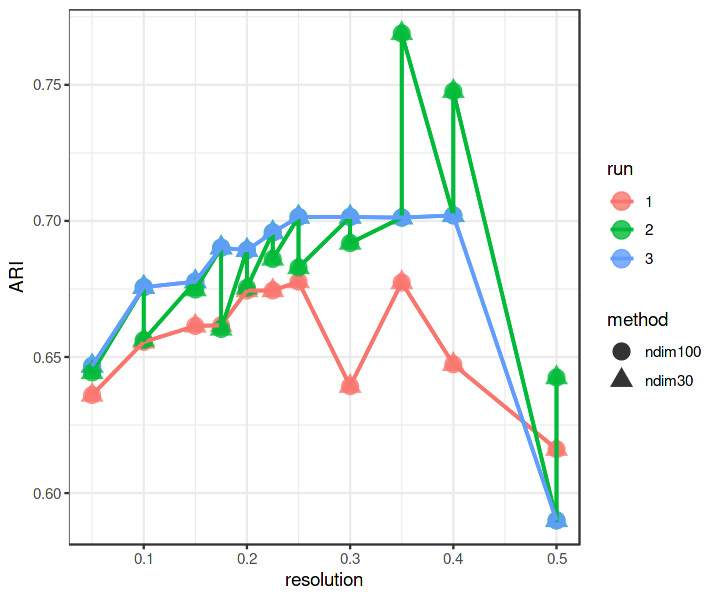

In [51]:
options(repr.plot.width=6, repr.plot.height=5)

df %>% 
  ggplot(aes(x=resolution, y=ARI, color=run, shape = method)) + 
  geom_point(size=4.5, alpha=0.8) +
  geom_line(size=0.8, aes(x=resolution, y=ARI, color=run)) + 
  xlab("resolution") +
  ylab("ARI") +
#   geom_vline(xintercept=15, color = "red", linetype = "dashed") +
  theme_bw() #+
  # geom_errorbar(aes(ymin = min_value, ymax = max_value), width = 0.2, linetype = "dashed") +
#   scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)])

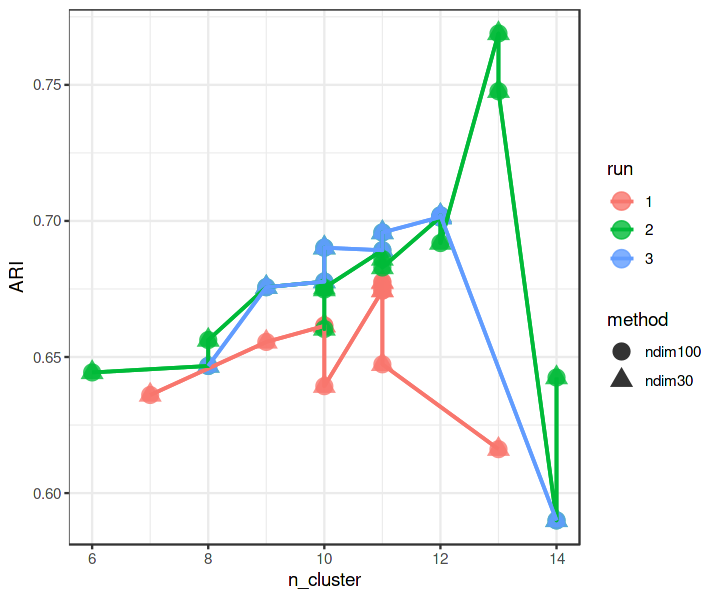

In [50]:
options(repr.plot.width=6, repr.plot.height=5)

df %>% 
  ggplot(aes(x=n_cluster, y=ARI, color=run, shape = method)) + 
  geom_point(size=4.5, alpha=0.8) +
  geom_line(size=0.8, aes(x=n_cluster, y=ARI, color=run)) + 
  xlab("n_cluster") +
  ylab("ARI") +
#   geom_vline(xintercept=15, color = "red", linetype = "dashed") +
  theme_bw() #+
  # geom_errorbar(aes(ymin = min_value, ymax = max_value), width = 0.2, linetype = "dashed") +
#   scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)])

In [32]:
getwd()

[1] "/home/siluo/public/SiyuanLuo/projects/benchmark/scripts/analysis/randomness"

In [47]:
write.table(df, "agg_randomness_PBMC_multiomics.tsv", sep="\t", quote = FALSE,)

## Try using all cells

In [5]:
setwd("~/public/SiyuanLuo/projects/benchmark/scripts/analysis/randomness")
sobj <- readRDS("~/public/SiyuanLuo/projects/benchmark/outputs/PBMC_multiomics/PBMC_multiomics/feature_engineering/R/Signac/by_cluster_peaks/0/default/15.RDS")
feature_matrix <- GetAssayData(sobj[["by_cluster_peaks"]], slot = "counts") # feature-by-cell matrix!
feature_matrix <- t(feature_matrix)

Loading required package: Signac



In [9]:
dims=seq(2L, 12L)
n_meta_features=1000
n_cells=20000
norm_method='tfidf' 
reduce="pca"
ndim=100
norm_function <- Signac::RunTFIDF

embed <- aggregate_features(feature_matrix=feature_matrix, dims=dims, n_meta_features=n_meta_features, n_cells=n_cells, norm_function=norm_function, reduce=reduce, sce=NULL)
counts <- Matrix::rowSums(feature_matrix)
embed <- embed[, seq_len(length.out = ndim)]
components <- DepthCorComponents(embed, counts, 0.75, ndim)
agg_feature_matrix <- embed[, components]

Loading required package: scDblFinder

Performing TF-IDF normalization



In [24]:
write.table(agg_feature_matrix, file = "PBMC_multiomics_Agg_ndim100.all_cells.tsv", sep = "\t", quote = FALSE, col.names = FALSE)

In [25]:
sobj <- readRDS("~/public/SiyuanLuo/projects/benchmark/outputs/PBMC_multiomics/PBMC_multiomics/clustering/aggregation/default/500/default/30/sobj_SNN.RDS")

# embedding_file <- "PBMC_multiomics_Agg_ndim100.tsv"
# sobj1 <- add_embedding(sobj, embedding_file, embed_name="run3_ndim30", max_dim=30)
# sobj2 <- add_embedding(sobj, embedding_file, embed_name="run3_ndim100", max_dim=100)

# embedding_file <- "PBMC_multiomics_Agg_ndim100.2.tsv"
# sobj1 <- add_embedding(sobj1, embedding_file, embed_name="run4_ndim30", max_dim=30)
# sobj2 <- add_embedding(sobj2, embedding_file, embed_name="run4_ndim100", max_dim=100)

embedding_file <- "PBMC_multiomics_Agg_ndim100.all_cells.tsv"
sobj1 <- add_embedding(sobj, embedding_file, embed_name="all_cells_ndim30", max_dim=30)

Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”


In [26]:
embed_ls <- c("all_cells_ndim30")
r_ls <- c(0.05, 0.1, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3,0.4,0.5)

embed_name <- embed_ls[1]
name1 <- paste0("nn_", embed_name)
name2 <- paste0("snn_", embed_name)
sobj1 <- FindNeighbors(object = sobj1, 
                        reduction = embed_name, 
                        graph.name = c(name1, name2)
                    )
sobj1@graphs[[name1]] <- as.Graph(sobj1@graphs[[name1]])
sobj1@graphs[[name2]] <- as.Graph(sobj1@graphs[[name2]])
ndim0 <- dim(sobj1@reductions[[embed_name]])[2]
sobj1 <- RunUMAP(sobj1, 
        reduction = embed_name,
        dims = 1:ndim0,
        reduction.name=paste0("umap_" ,embed_name))
for(r in r_ls){
    sobj1 <- FindClusters(object = sobj1, 
                verbose = FALSE, 
                algorithm = 4,
                resolution = r,
                graph.name = name2
                )
    sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj1$seurat_clusters
}

Computing nearest neighbor graph

Computing SNN

13:31:03 UMAP embedding parameters a = 0.9922 b = 1.112

13:31:03 Read 8560 rows and found 30 numeric columns

13:31:03 Using Annoy for neighbor search, n_neighbors = 30

13:31:03 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:31:04 Writing NN index file to temp file /media/siluo/c55ed6ce-672c-4a68-b60e-cef07edf5933/scratch/Rtmp7YsGFd/file3b7706733638

13:31:04 Searching Annoy index using 1 thread, search_k = 3000

13:31:06 Annoy recall = 100%

13:31:08 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:31:10 Found 2 connected components, 
falling back to 'spca' initialization with init_sdev = 1

13:31:10 Using 'irlba' for PCA

13:31:10 PCA: 2 components explained 66.18% varia

In [27]:
df <- data.frame(ARI=c(), resolution=c(), method=c(), n_cluster=c())
embed_name <- embed_ls[1]
for(r in r_ls){
    pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
    ari <- aricode::ARI(sobj1$ground_truth, pred)
    # print(embed_name)
    # print(ari)
    # print(max(as.numeric(unique(pred))))
    df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred))), run=2))
}   

In [28]:
df

ARI       resolution method           n_cluster run
1  0.6314900 0.050      all_cells_ndim30  6        2  
2  0.7435043 0.100      all_cells_ndim30  8        2  
3  0.8412166 0.150      all_cells_ndim30 10        2  
4  0.8062980 0.175      all_cells_ndim30 10        2  
5  0.8087798 0.200      all_cells_ndim30 11        2  
6  0.6740332 0.225      all_cells_ndim30 11        2  
7  0.6754113 0.250      all_cells_ndim30 12        2  
8  0.6770324 0.300      all_cells_ndim30 12        2  
9  0.6647010 0.400      all_cells_ndim30 13        2  
10 0.6725106 0.500      all_cells_ndim30 14        2

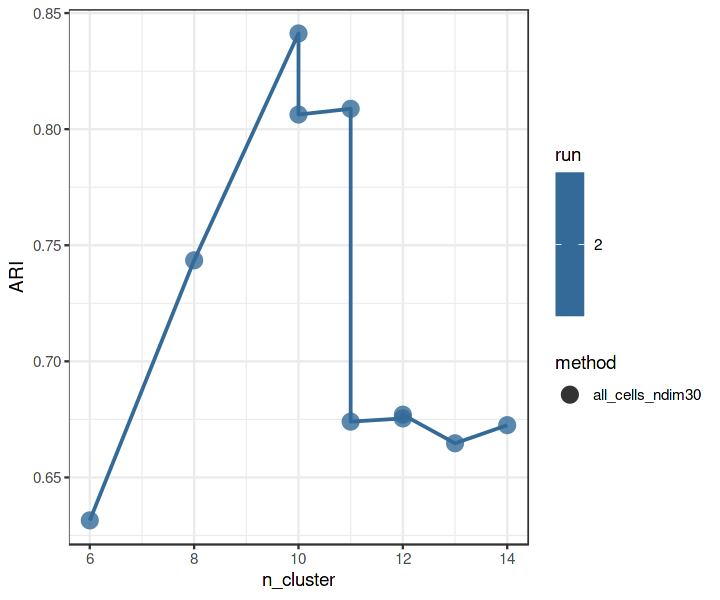

In [34]:
options(repr.plot.width=6, repr.plot.height=5)

df %>% 
  ggplot(aes(x=n_cluster, y=ARI, color=run, shape = method)) + 
  geom_point(size=4.5, alpha=0.8) +
  geom_line(size=0.8, aes(x=n_cluster, y=ARI, color=run)) + 
  xlab("n_cluster") +
  ylab("ARI") +
#   geom_vline(xintercept=15, color = "red", linetype = "dashed") +
  theme_bw() #+
  # geom_errorbar(aes(ymin = min_value, ymax = max_value), width = 0.2, linetype = "dashed") +
#   scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)])

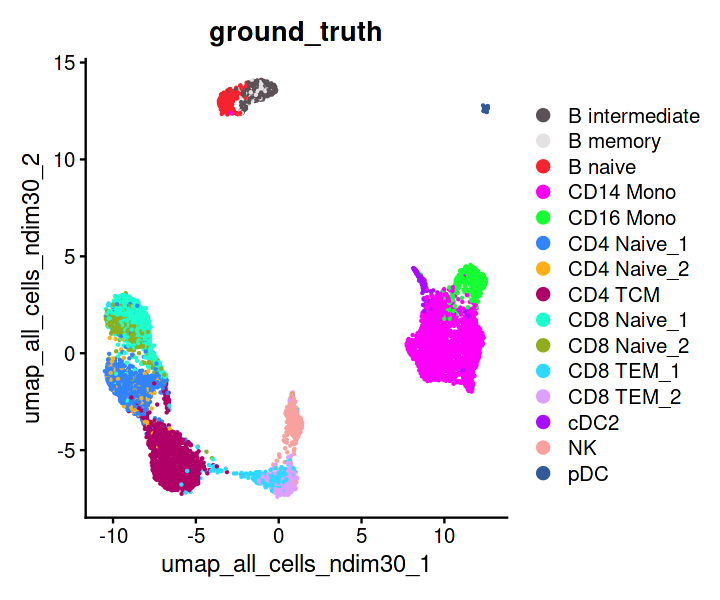

In [31]:
DimPlot(sobj1, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  #+ ggtitle(paste0(lm,"_ndim",n))

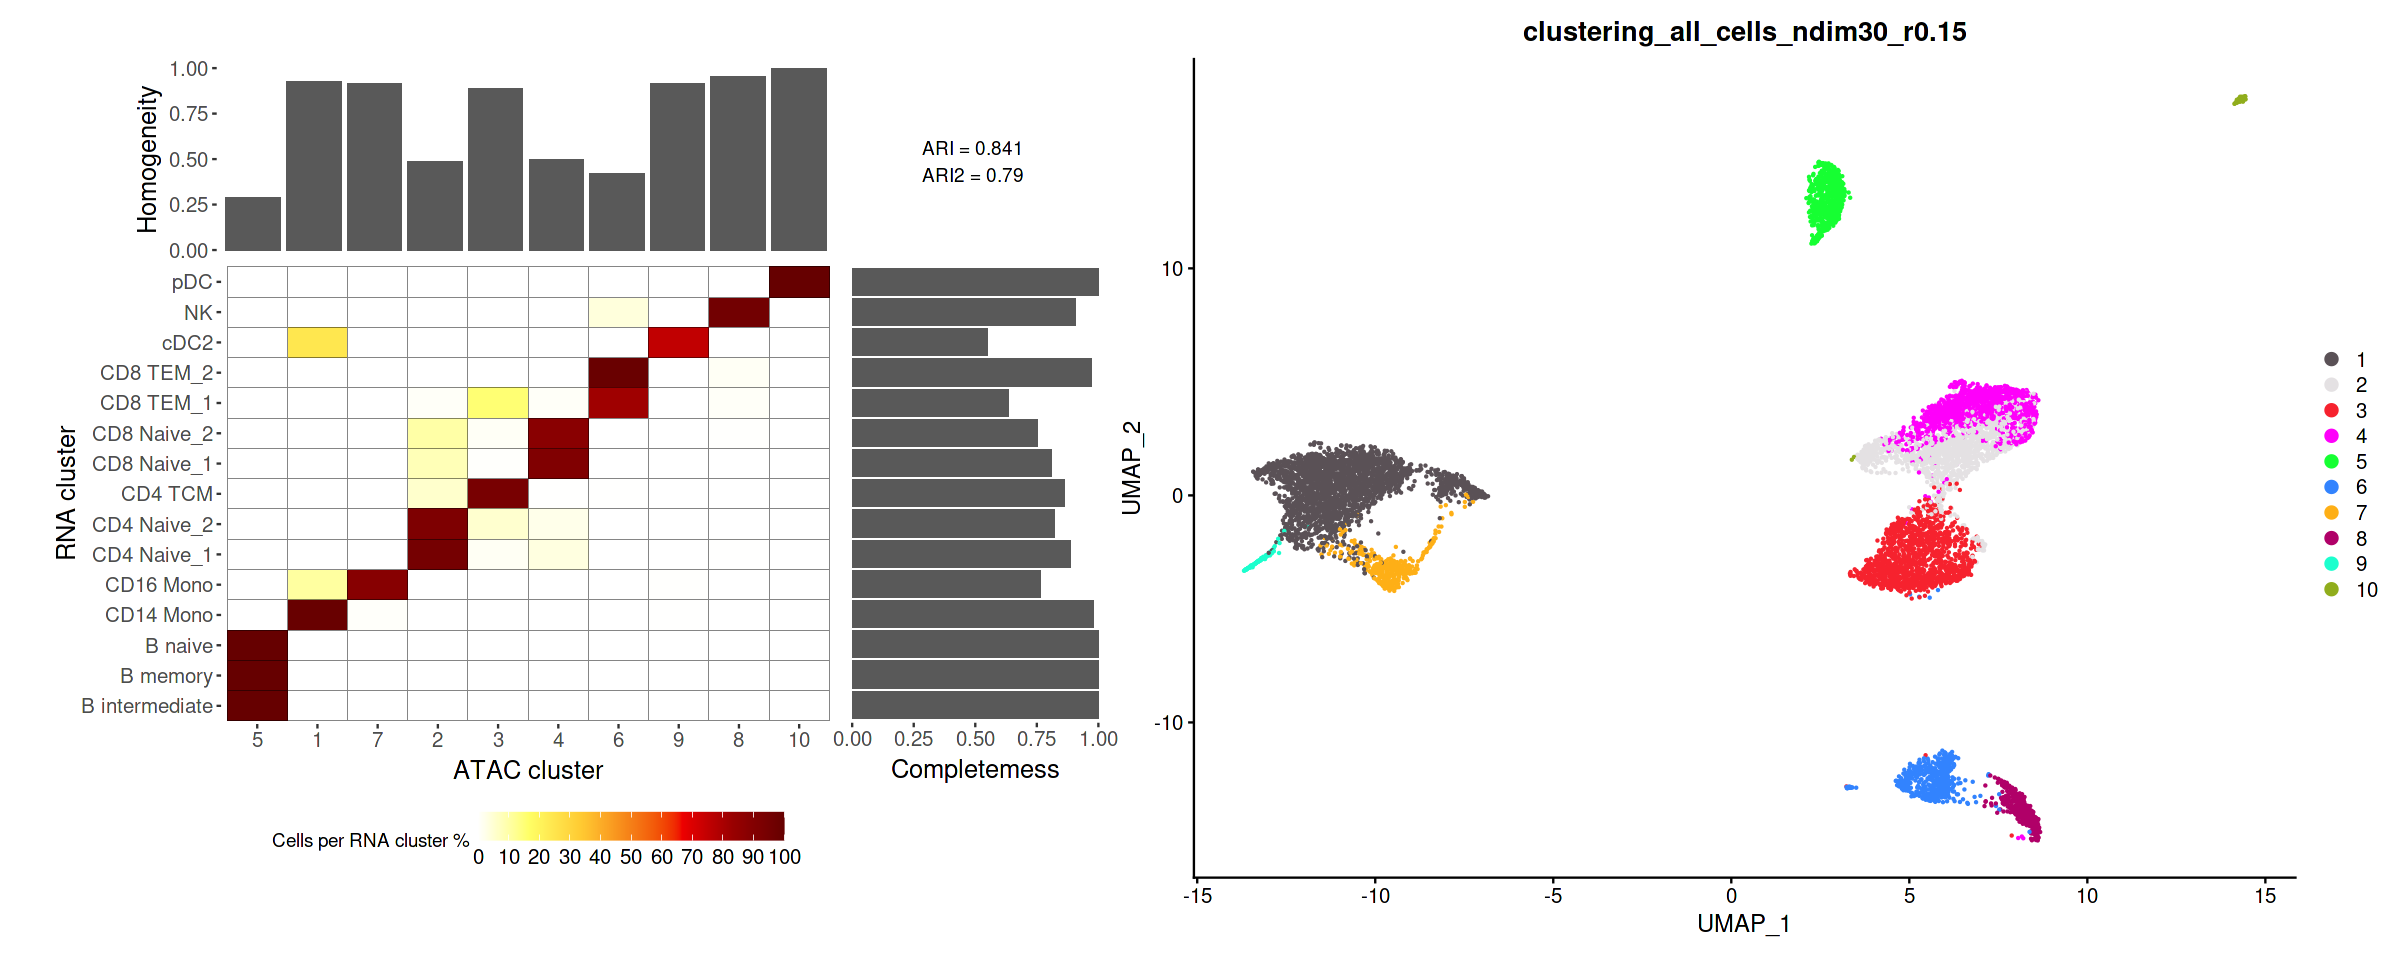

In [37]:
options(repr.plot.width=20, repr.plot.height=8)

r <- 0.15

pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(sobj1$ground_truth, pred, a=1.3, b=2.7, c=2)
p2 <- DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 

p1 + p2

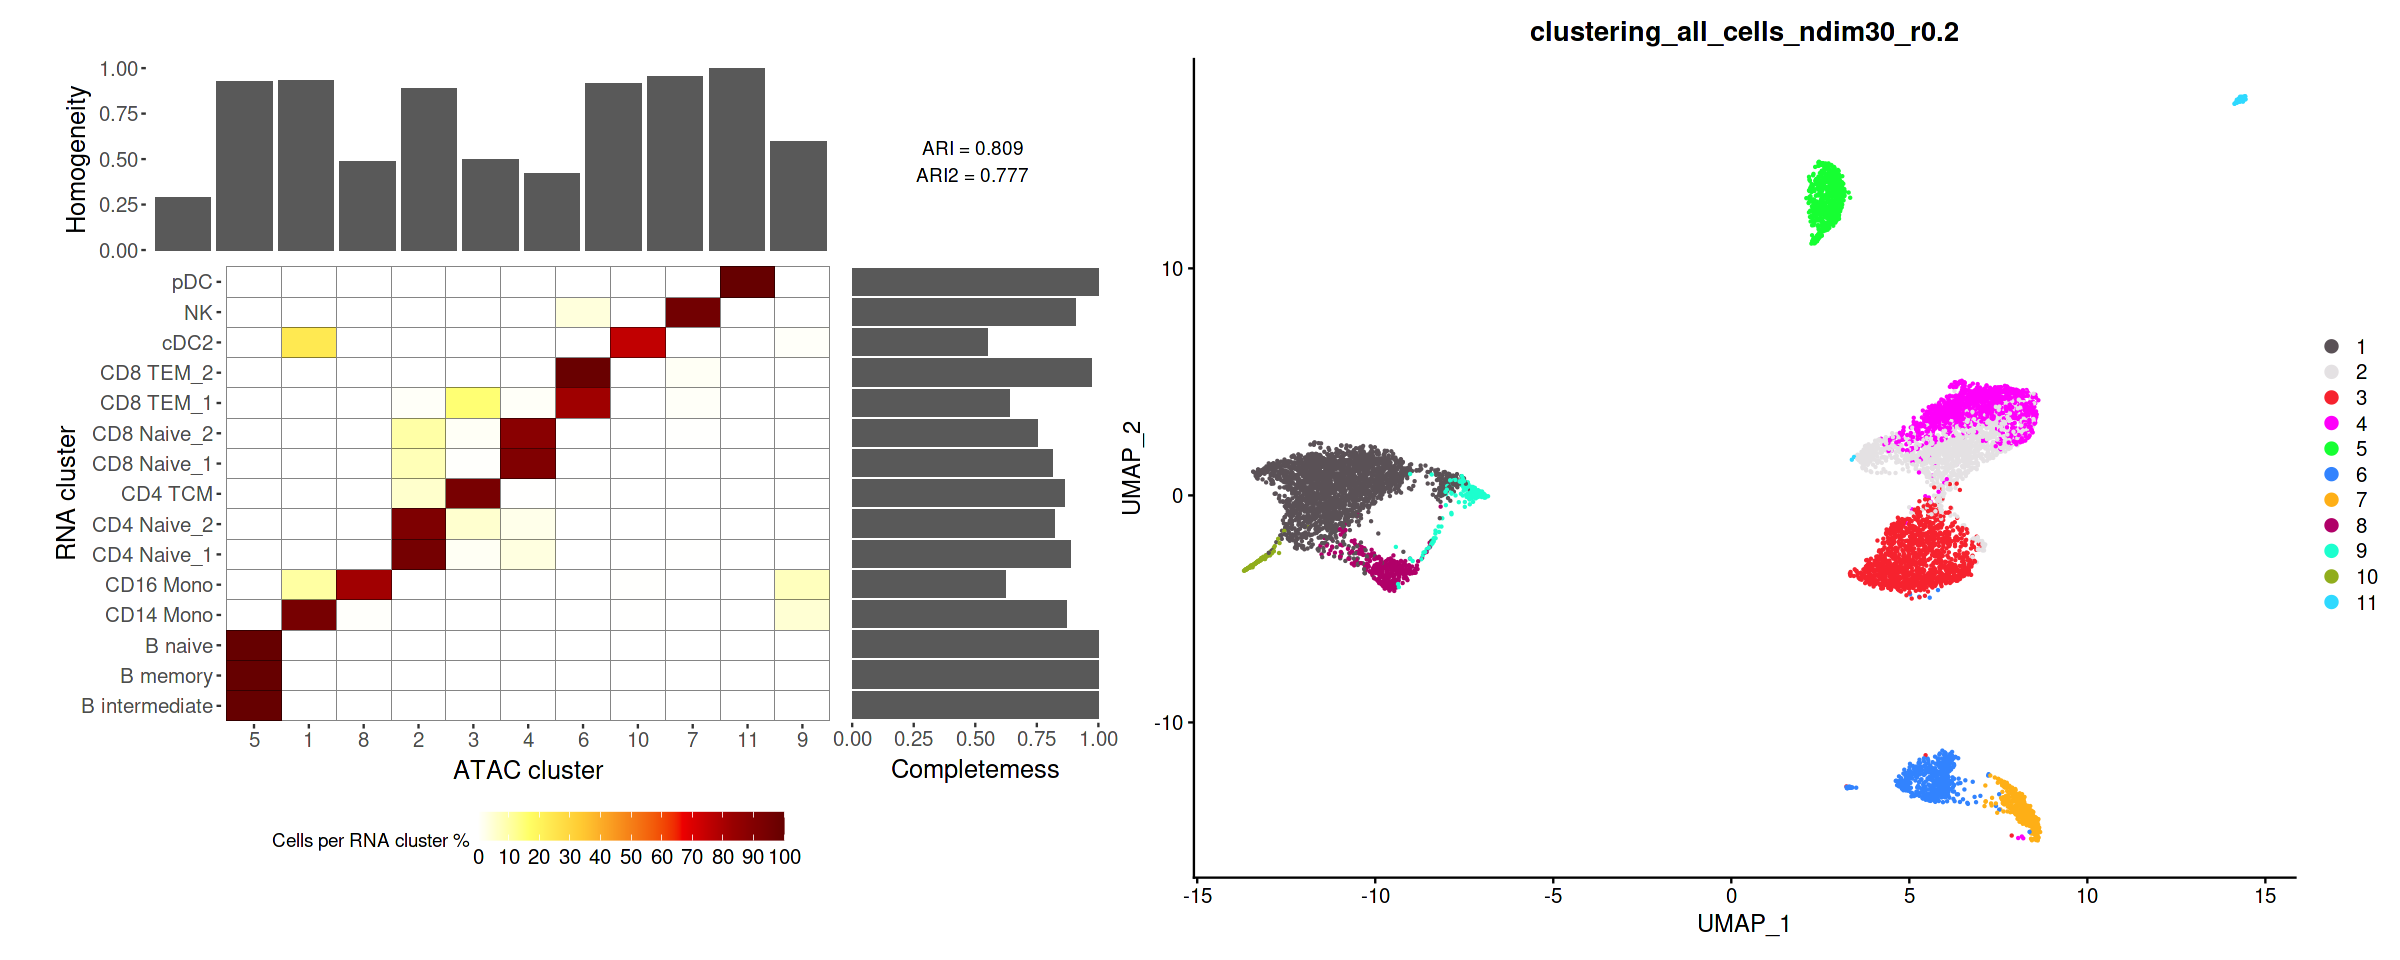

In [35]:
options(repr.plot.width=20, repr.plot.height=8)

r <- 0.2

pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(sobj1$ground_truth, pred, a=1.3, b=1.2, c=2)
p2 <- DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 

p1 + p2

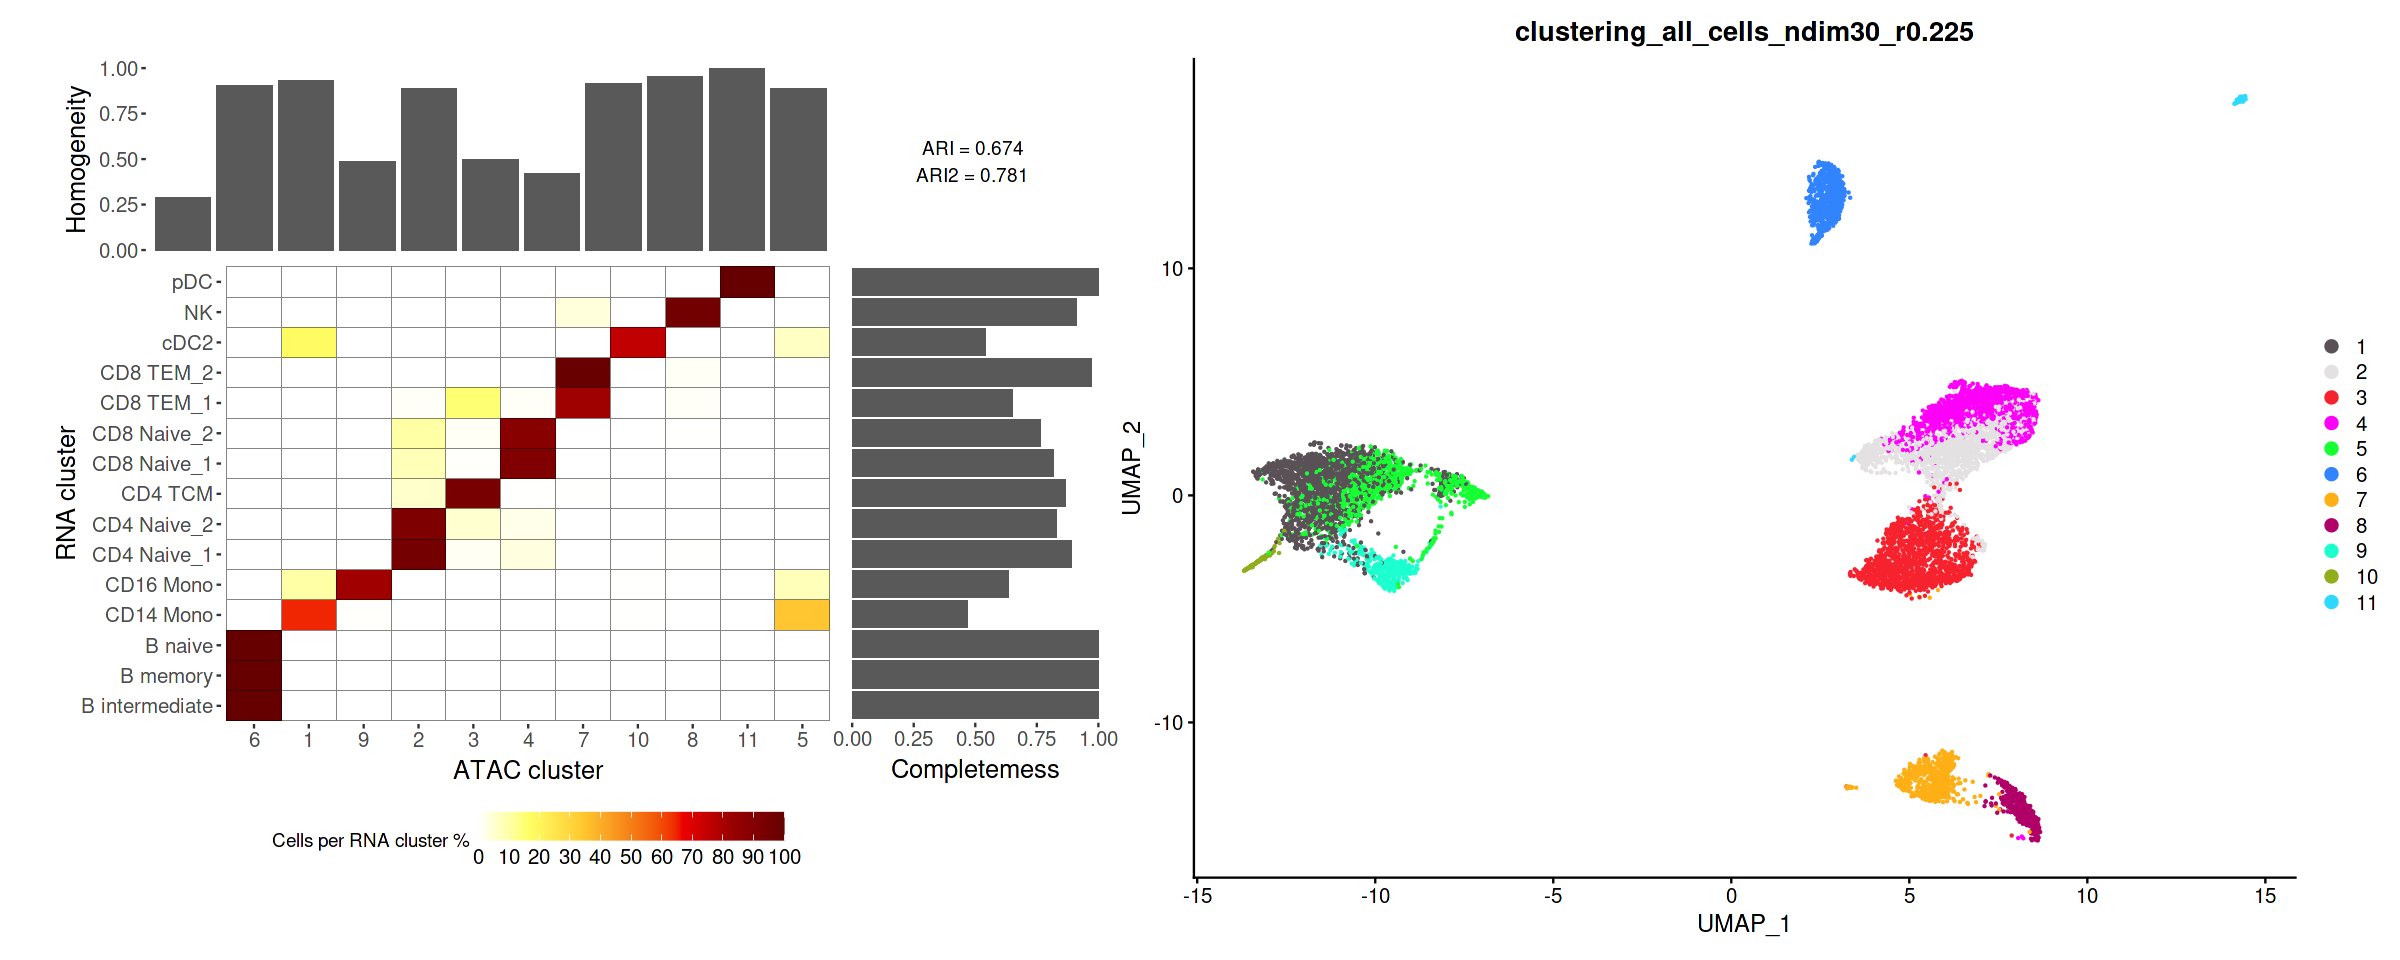

In [36]:
options(repr.plot.width=20, repr.plot.height=8)

r <- 0.225

pred <- sobj1@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(sobj1$ground_truth, pred, a=1.3, b=1.2, c=2)
p2 <- DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 

p1 + p2